In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import datetime as dt
from scipy.stats.stats import pearsonr
from copy import deepcopy

In [2]:
path = "/home/koki/Desktop/Data/OutOfStock/LEMeldungen_2021-11-01-16-50-35.csv"
df = pd.read_csv(path, sep=';')

In [3]:
df.head()

,PZN,ENR,Meldungsart,Beginn,Ende,Datum der letzten Meldung,Art des Grundes,Arzneimittlbezeichnung,Atc Code,Wirkstoffe,Krankenhausrelevant,Zulassungsinhaber,Telefon,E-Mail,Grund,Anm. zum Grund,Alternativpr�parat,Datum der Erstmeldung,Info an Fachkreise
0,"01008363, 04575772, 07591079",2139268,Erstmeldung,11.11.2021,24.01.2022,01.11.2021,Produktionsproblem,ZOLADEX-GYN,L02AE03,Goserelinacetat (1:x),ja,AstraZeneca GmbH,0800-2288660,service.center@astrazeneca.com,Sonstige,NaN,"Enantone-Gyn Monats-Depot 3,75mg Retardmikroka...",01.11.2021,Nein
1,"01128015, 06715970, 06715987",2163658,�nderungsmeldung,03.09.2021,29.01.2022,29.10.2021,Sonstige,Octreotid HEXAL 100 Mikrogramm/ml,H01CB02,Octreotidacetat (1:x),nein,Hexal Aktiengesellschaft,0800-4392527,service@hexal.com,Sonstige,NaN,NaN,03.09.2021,Vorgesehen
2,"06715993, 06716001",2163657,Erstmeldung,29.10.2021,29.01.2022,29.10.2021,Sonstige,Octreotid HEXAL 50 Mikrogramm/ml,H01CB02,Octreotidacetat (1:x),nein,Hexal Aktiengesellschaft,0800-4392527,service@hexal.com,Sonstige,NaN,NaN,29.10.2021,Vorgesehen
3,01872392,424272,�nderungsmeldung,11.10.2021,14.12.2021,28.10.2021,Produktionsproblem,Fucidine 20 mg/g Salbe,D06AX01,Natriumfusidat,ja,Leo Pharma A/S Beiname: Leo Pharmaceutical Pro...,+4961022010,regulatory_affairs_de@leo-pharma.com,Probleme in der Herstellung,NaN,Fucidine 20 mg/g Salbe - Einreichungsnummer: 0...,11.10.2021,Nein
4,01462323,424272,L�schmeldung,18.10.2021,19.10.2021,28.10.2021,Produktionsproblem,Fucidine 20 mg/g Salbe,D06AX01,Natriumfusidat,ja,Leo Pharma A/S Beiname: Leo Pharmaceutical Pro...,+4961022010,regulatory_affairs_de@leo-pharma.com,Probleme in der Herstellung,NaN,Fucidine 20 mg/g Salbe - Einreichungsnummer: 0...,11.10.2021,Nein


In [4]:
df.shape

(1582, 19)

In [5]:
df['Beginn'] = pd.to_datetime(df['Beginn'], format='%d.%m.%Y')
df['Ende'] = pd.to_datetime(df['Ende'], format='%d.%m.%Y')

In [6]:
# Add as a feature the number of days a medication was out of stock
df['days'] = (df['Ende'] - df['Beginn']).dt.days

In [7]:
df[['Beginn', 'Ende', 'days']].head()

,Beginn,Ende,days
0,2021-11-11,2022-01-24,74
1,2021-09-03,2022-01-29,148
2,2021-10-29,2022-01-29,92
3,2021-10-11,2021-12-14,64
4,2021-10-18,2021-10-19,1


## Functions for grouping companies and active ingredients

In [8]:
def standartize_string(x):
    x = str(x)
    x = x.split()[0]
    x = x.lower()
    x = re.sub("[\(\)]", "", x)
    return x

In [9]:
def get_wirkstoff(x,sep=';'):
    if x != x:
        return ["Missing"]
    x = str(x)
    ws = x.split(sep)
    res = []
    for w in ws:
        w = re.sub("[\(\[].*?[\)\]]", "", w)
        w = re.sub("[\(\)]", "", w)
        w = w.strip()
        res.append(w)
    return res

In [10]:
df['wirkstoff'] = df['Wirkstoffe'].apply(lambda x : get_wirkstoff(x))

In [11]:
list(df['wirkstoff'])[:6]

[['Goserelinacetat'],
 ['Octreotidacetat'],
 ['Octreotidacetat'],
 ['Natriumfusidat'],
 ['Natriumfusidat'],
 ['Vinorelbinbis-tartrat]']]

In [12]:
names = {}
for name in df['Zulassungsinhaber'].unique():
    new_name = standartize_string(name)
    names.setdefault(new_name, [])
    names[new_name].append(name)
    
unique_names = {}
for _, inhaber in names.items():
    for inh in inhaber:
        unique_names[inh] = inhaber[0]

In [13]:
len(unique_names), len(names)

(184, 147)

In [14]:
df = df.replace({"Zulassungsinhaber": unique_names})

In [15]:
max(df['Ende'])

Timestamp('2026-05-31 00:00:00')

In [16]:
df[['Zulassungsinhaber', 'wirkstoff', 'Beginn', 'Ende', 'days']].head(10)

,Zulassungsinhaber,wirkstoff,Beginn,Ende,days
0,AstraZeneca GmbH,[Goserelinacetat],2021-11-11,2022-01-24,74
1,Hexal Aktiengesellschaft,[Octreotidacetat],2021-09-03,2022-01-29,148
2,Hexal Aktiengesellschaft,[Octreotidacetat],2021-10-29,2022-01-29,92
3,Leo Pharma A/S Beiname: Leo Pharmaceutical Pro...,[Natriumfusidat],2021-10-11,2021-12-14,64
4,Leo Pharma A/S Beiname: Leo Pharmaceutical Pro...,[Natriumfusidat],2021-10-18,2021-10-19,1
5,Hexal Aktiengesellschaft,[Vinorelbinbis-tartrat]],2021-07-01,2022-03-25,267
6,1 A Pharma GmbH,[Rivastigmin],2021-09-17,2021-10-28,41
7,Hexal Aktiengesellschaft,[Isotretinoin],2020-05-01,2021-11-30,578
8,ALIUD PHARMA GmbH,[Cefixim 3 H<2>O],2018-10-01,2021-12-31,1187
9,KEDRION S.p.A. Localita ai Conti,[Immunglobulin G vom Menschen],2021-10-01,2022-04-01,182


In [17]:
months = []
years = []
for _,row in df.iterrows():
    months_feat = Counter(pd.date_range(row['Beginn'], row['Ende']+  pd.DateOffset(days=29), 
                                        freq='M').strftime("%b").tolist())
    years_feat = Counter(pd.date_range(row['Beginn'], row['Ende']+ pd.DateOffset(days=29), freq='M').strftime("%Y").tolist())
    months.append(months_feat)
    years.append({y: int(365*(v/12)) for y, v in years_feat.items()})
df['months'] = months   
df['years'] = years

In [18]:
df[['Zulassungsinhaber', 'wirkstoff', 'Beginn', 'Ende', 'days', 'months', 'years']].head()

,Zulassungsinhaber,wirkstoff,Beginn,Ende,days,months,years
0,AstraZeneca GmbH,[Goserelinacetat],2021-11-11,2022-01-24,74,"{'Nov': 1, 'Dec': 1, 'Jan': 1}","{'2021': 60, '2022': 30}"
1,Hexal Aktiengesellschaft,[Octreotidacetat],2021-09-03,2022-01-29,148,"{'Sep': 1, 'Oct': 1, 'Nov': 1, 'Dec': 1, 'Jan'...","{'2021': 121, '2022': 30}"
2,Hexal Aktiengesellschaft,[Octreotidacetat],2021-10-29,2022-01-29,92,"{'Oct': 1, 'Nov': 1, 'Dec': 1, 'Jan': 1}","{'2021': 91, '2022': 30}"
3,Leo Pharma A/S Beiname: Leo Pharmaceutical Pro...,[Natriumfusidat],2021-10-11,2021-12-14,64,"{'Oct': 1, 'Nov': 1, 'Dec': 1}",{'2021': 91}
4,Leo Pharma A/S Beiname: Leo Pharmaceutical Pro...,[Natriumfusidat],2021-10-18,2021-10-19,1,{'Oct': 1},{'2021': 30}


In [19]:
df = df[df['days']>=0]

In [20]:
path = "/home/koki/Desktop/Data/OutOfStock/preprocessed.csv"
df[['Zulassungsinhaber', 'wirkstoff', 'Beginn', 'Ende', 'days', 'months', 'years']].to_csv(path, index=False)

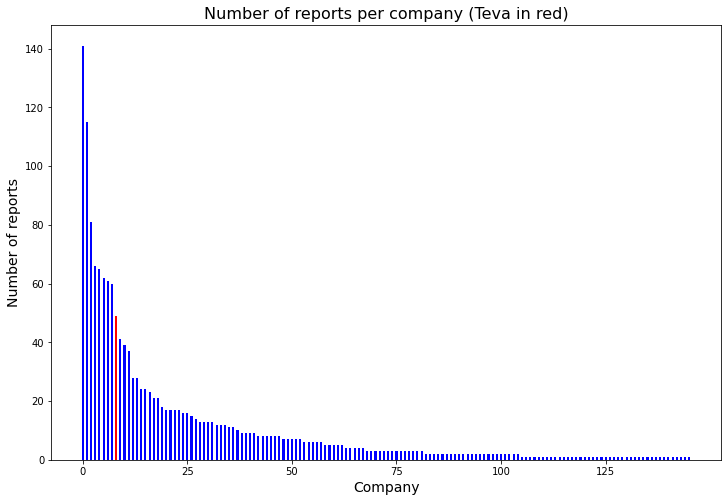

In [21]:
counts = sorted([(v, k) for k,v in df['Zulassungsinhaber'].value_counts().to_dict().items()], reverse=True)[:1200]
plt.figure(figsize=(12, 8))
colors = ['b' for _ in range(len(counts))]
for i, c in enumerate(counts):
    if 'TEVA' in c[1]:
        colors[i] = 'r'
plt.bar(x=[2*i for i in range(len(counts))], height = [c[0] for c in counts], width=1, color=colors)
#plt.plot([c[0] for c in counts])
plt.xlabel("Company", fontsize=14)
plt.ylabel("Number of reports", fontsize=14)
plt.title("Number of reports per company (Teva in red)", fontsize=16)
plt.xticks([i for i in range(0, 2*len(counts), 50)], [i//2 for i in range(0, 2*len(counts), 50)])
if len(counts) <=20:
    x_labels = [" ".join(c[1].split()[:3]) for c in counts]
    plt.xticks([2*i for i in range(len(counts))], x_labels, fontsize=14, rotation=90)
    idx = -1
    for i,lb in enumerate(x_labels):
        if 'TEVA' in lb:
            idx = i
    plt.gca().get_xticklabels()[idx].set_color("red")
plt.show()

In [22]:
len(counts)

146

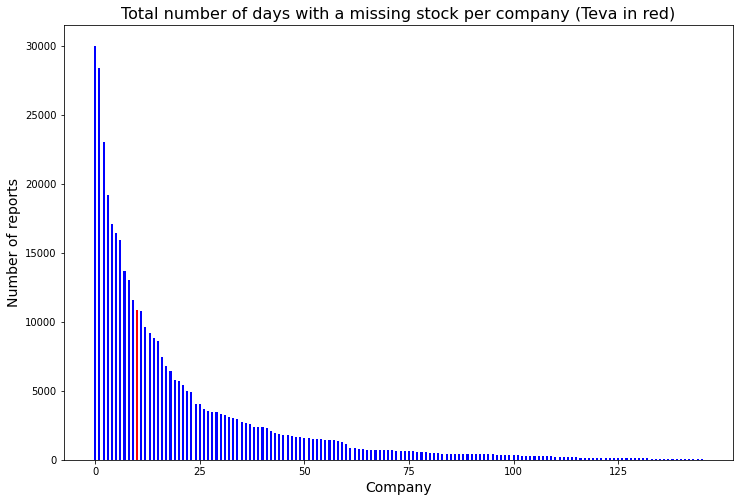

In [23]:
counts = sorted([(v, k) for k,v in df.groupby(['Zulassungsinhaber'])['days'].agg('sum').to_dict().items()], 
                reverse=True)[:1200]
plt.figure(figsize=(12, 8))
colors = ['b' for _ in range(len(counts))]
for i, c in enumerate(counts):
    if 'TEVA' in c[1]:
        colors[i] = 'r'
plt.bar(x=[2*i for i in range(len(counts))], height = [c[0] for c in counts], width=1, color=colors)
#plt.plot([c[0] for c in counts])
plt.xlabel("Company", fontsize=14)
plt.ylabel("Number of reports", fontsize=14)
plt.title("Total number of days with a missing stock per company (Teva in red)", fontsize=16)
plt.xticks([i for i in range(0, 2*len(counts), 50)], [i//2 for i in range(0, 2*len(counts), 50)])
if len(counts) <=20:
    x_labels = [" ".join(c[1].split()[:3]) for c in counts]
    plt.xticks([2*i for i in range(len(counts))], x_labels, fontsize=14, rotation=90)
    idx = -1
    for i,lb in enumerate(x_labels):
        if 'TEVA' in lb:
            idx = i
    plt.gca().get_xticklabels()[idx].set_color("red")
plt.show()

In [24]:
df['Arzneimittlbezeichnung'].unique()

array(['ZOLADEX-GYN', 'Octreotid HEXAL 100 Mikrogramm/ml',
       'Octreotid HEXAL 50 Mikrogramm/ml', ...,
       'InductOs 1,5 mg/ml Pulver, L�sungsmittel und Matrix f�r Matrix zur Implantation - OP(296,83mg+8ml+XXXX)',
       'Esidrix 25 mg Tabletten',
       'Fuzeon 90 mg/ml Pulver und L�sungsmittel zur Herstellung einer Injektionsl�sung - OP(60+60+Besteck)'],
      dtype=object)

Text(0.5, 1.0, 'Distribution of days per out-of-stock report')

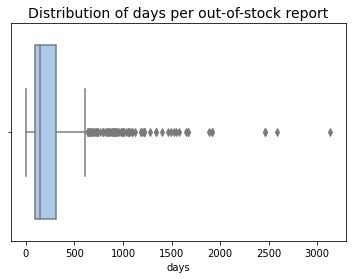

In [25]:
# sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=df['days'], color='green', palette='pastel', orient='h')
ax.set_title("Distribution of days per out-of-stock report", fontsize=14)
#ax.set_xscale('log')

In [26]:
df['days'].describe()

count    1581.000000
mean      258.823529
std       301.941957
min         0.000000
25%        90.000000
50%       150.000000
75%       305.000000
max      3135.000000
Name: days, dtype: float64

In [27]:
df[df['days']<=0][['Beginn', 'Ende', 'Zulassungsinhaber', 'Art des Grundes', 'Arzneimittlbezeichnung', 'days']]

,Beginn,Ende,Zulassungsinhaber,Art des Grundes,Arzneimittlbezeichnung,days
112,2021-10-01,2021-10-01,Hexal Aktiengesellschaft,Produktionsproblem,Estramon conti 40/130 Mikrogramm/24 h Transder...,0
113,2021-10-01,2021-10-01,Hexal Aktiengesellschaft,Produktionsproblem,Estramon conti 30/95 Mikrogramm/24 h Transderm...,0
167,2021-08-30,2021-08-30,Amdipharm Limited,Sonstige,Erythrocin-i.v.500mg,0


[Text(0, 0, 'Hexal Aktiengesellschaft'),
 Text(1, 0, '1 A Pharma'),
 Text(2, 0, 'ALIUD PHARMA GmbH'),
 Text(3, 0, 'Aspen Pharma Trading'),
 Text(4, 0, 'PUREN Pharma GmbH'),
 Text(5, 0, 'Pfizer Pharma PFE'),
 Text(6, 0, 'Sanofi-Aventis Deutschland GmbH'),
 Text(7, 0, 'Glenmark Arzneimittel GmbH'),
 Text(8, 0, 'ratiopharm GmbH'),
 Text(9, 0, 'TEVA GmbH'),
 Text(10, 0, 'Merck Serono GmbH'),
 Text(11, 0, 'STADAPHARM, Gesellschaft mit')]

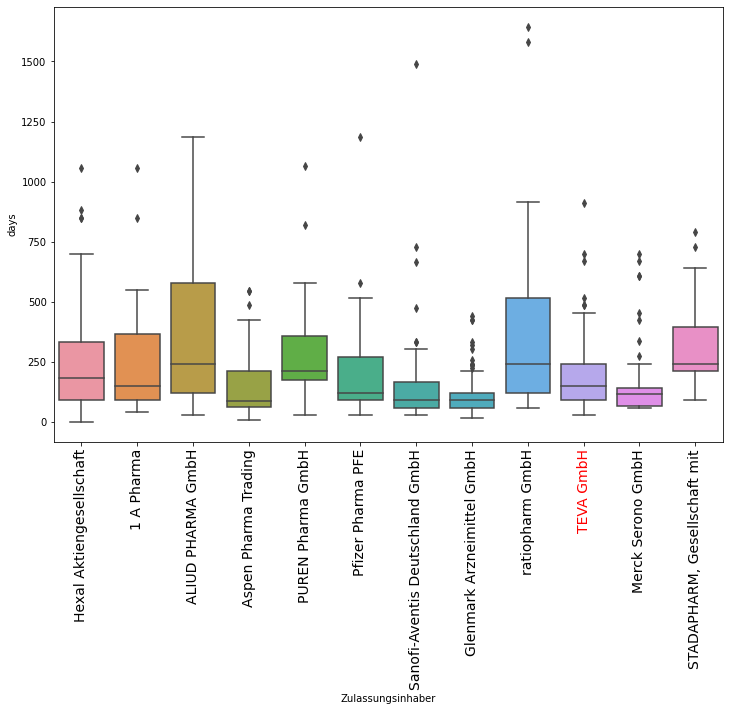

In [28]:
tops = [k for k, v in df['Zulassungsinhaber'].value_counts().to_dict().items()][:12]
df_top = df[df['Zulassungsinhaber'].isin(tops)]
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x='Zulassungsinhaber', y="days", data=df_top, orient='v')
x_labels = [" ".join(c.get_text().split()[:3]) for c in list(ax.get_xticklabels())]
idx = -1
for i,lb in enumerate(x_labels):
    if 'TEVA' in lb:
        idx = i
plt.gca().get_xticklabels()[idx].set_color("red")
ax.set_xticklabels(x_labels,rotation=90, fontsize=14)

In [29]:
def plot_wirkstoff_distr(df, top, per_day=True):
    vals = {}
    for ws, days in zip(df['wirkstoff'], df['days']):
        if days < 1:
            continue
        if not per_day:
            days = 1
        for w in ws:
            vals.setdefault(w, 0)
            vals[w] += days #df['Zulassungsinhaber'].nunique()
    sumvals = sum(vals.values())
    top_vals = sorted([(v,k) for k, v in vals.items()], reverse=True)[:top]
    top_ingredients = [v[1] for v in top_vals]
    plt.figure(figsize=(12, 8))
    plt.bar(list(range(len(top_vals))), [v[0]/sumvals for v in top_vals], width=0.5)
    plt.xlabel("Active ingredient", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    pr = "total days"
    if not per_day:
        pr = "number of reports"
    plt.title("Active ingredients distribution ({})".format(pr), fontsize=15)
    if top <=20:
        x_labels = top_ingredients[:top]
        x_labels = [" ".join(c.split()[:1]) for c in x_labels]
        plt.xticks(range(top), x_labels, fontsize=14, rotation=90)
    plt.show()
    print("Frequency of last item", top_vals[-1])
    print("Nr of unique active ingredients", len(vals))
    return {k: v for v,k in top_vals}, top_ingredients

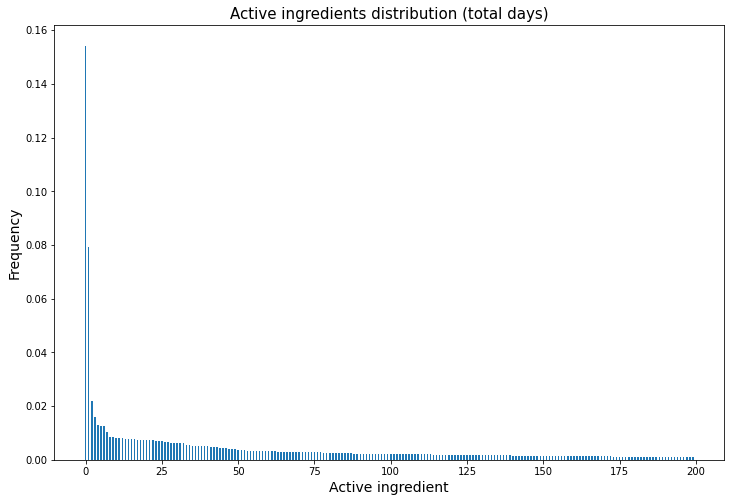

Frequency of last item (485, 'Ifosfamid')
Nr of unique active ingredients 515


In [30]:
top_vals_days, top_ingredients_days = plot_wirkstoff_distr(df, top=200)

In [31]:
top_ingredients_days

['Valsartan',
 'Hydrochlorothiazid',
 'Venlafaxinhydrochlorid',
 'Ranitidinhydrochlorid',
 'Piperacillin-Natrium',
 'Levodopa',
 'Urokinase',
 'Benserazidhydrochlorid',
 'Nifedipin',
 'Levothyroxin-Natrium',
 'Levothyroxin-Natrium  x H<2>O',
 'Mometasonfuroat',
 'Pankreas-Pulver vom Schwein',
 'Sulbactam-Natrium',
 'Belatacept',
 'Pregabalin',
 'Morphinsulfat',
 'Ampicillin-Natrium',
 'Fentanylcitrat',
 'Tazobactam-Natrium',
 'Immunglobulin G vom Menschen',
 'Phenoxymethylpenicillin-Kalium',
 'Ibuprofen',
 'Erythromycinethylsuccinat',
 'Methotrexat-Dinatrium',
 'Everolimus',
 'Natrium',
 'Tiopronin',
 'Cefixim 3 H<2>O',
 'Streptomycinsulfat',
 'Bromocriptinmesilat',
 'Lamotrigin',
 'Kaliumiodid',
 'Candesartancilexetil',
 'Remifentanilhydrochlorid',
 'Vinorelbinbis-tartrat]',
 'Prednisolonacetat',
 'Paracetamol',
 'Rizatriptanbenzoat',
 'Nitrofurantoin',
 'Desmopressinacetat',
 'Simvastatin',
 'Topiramat',
 'Cytarabin',
 'Zoledrons�ure  1 H<2>O',
 'Linezolid',
 'Metildigoxin-Aceton',
 

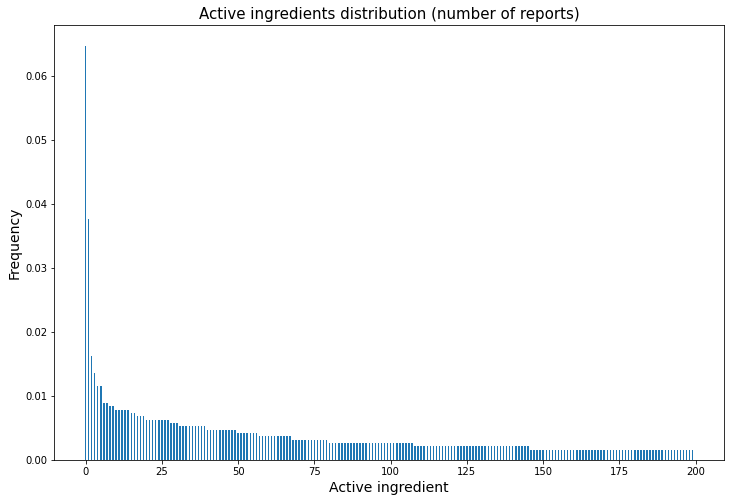

Frequency of last item (3, 'Albendazol')
Nr of unique active ingredients 515


In [31]:
top_vals_reports, top_ingredients_reports = plot_wirkstoff_distr(df, top=200, per_day=False)

In [32]:
sum(df['wirkstoff'].apply(len)>1)/len(df['wirkstoff'])

0.14041745730550284

In [33]:
def compare_distr(map1, map2):
    vec1 = []
    vec2 = []
    for k, v in map1.items():
        vec1.append(v)
        vec2.append(map2.get(k, 0))
    print("Pearson correlation:", pearsonr(vec1, vec2))

In [34]:
compare_distr(top_vals_days, top_vals_reports)

Pearson correlation: (0.9207089776716789, 7.488938677602809e-83)


In [35]:
top_ingredients_days[:4], top_ingredients_reports[:4]

(['Valsartan',
  'Hydrochlorothiazid',
  'Venlafaxinhydrochlorid',
  'Ranitidinhydrochlorid'],
 ['Valsartan',
  'Hydrochlorothiazid',
  'Levothyroxin-Natrium',
  'Venlafaxinhydrochlorid'])

In [36]:
def plot_wirkstoff_distr_per_company(df, company, top_ingredients, top = 50, normalize = True, plotit = True):
    vals = {}
    df_comp = df[df["Zulassungsinhaber"]==company]
    for ws, days in zip(df_comp['wirkstoff'], df_comp['days']):
        for w in ws:
            vals.setdefault(w, 0)
            denom = 1
            if normalize:
                denom = sum(df_comp['days'])
            vals[w] += days/denom #df['Zulassungsinhaber'].nunique()
    distr_vals = [vals.get(w, 0) for w in top_ingredients[:top]]
    if plotit:
        plt.figure(figsize=(12, 8))
        plt.bar(list(range(len(distr_vals))), distr_vals)
        plt.title("Distribution for " + company)
        plt.xlabel("Active ingredient", fontsize=14)
        plt.ylabel("Frequency", fontsize=14)
        if top <=15:
            x_labels = top_ingredients[:top]
            plt.xticks(range(top), x_labels, fontsize=14, rotation=90)
        plt.show()    
    return vals

In [37]:
def plot_wirkstoff_distr_per_company_per_year(df, company, year, top_ingredients, top = 50, plotit = True):
    vals = {}
    df_comp = df[df["Zulassungsinhaber"]==company]
    for ws, years_dict in zip(df_comp['wirkstoff'], df_comp['years']):
        for w in ws:
            vals.setdefault(w, 0)
            vals[w] += years_dict.get(str(year), 0) #df['Zulassungsinhaber'].nunique()
    distr_vals = [vals.get(w, 0) for w in top_ingredients[:top]]
    if plotit:
        plt.figure(figsize=(12, 8))
        plt.bar(list(range(len(distr_vals))), distr_vals)
        plt.title("Distribution for {} for year {}".format(company, year))
        plt.xlabel("Active ingredient", fontsize=14)
        plt.ylabel("Frequency", fontsize=14)
        if top <=15:
            x_labels = top_ingredients[:top]
            plt.xticks(range(top), x_labels, fontsize=14, rotation=90)
        plt.show()    
    return vals

Company Glenmark Arzneimittel GmbH


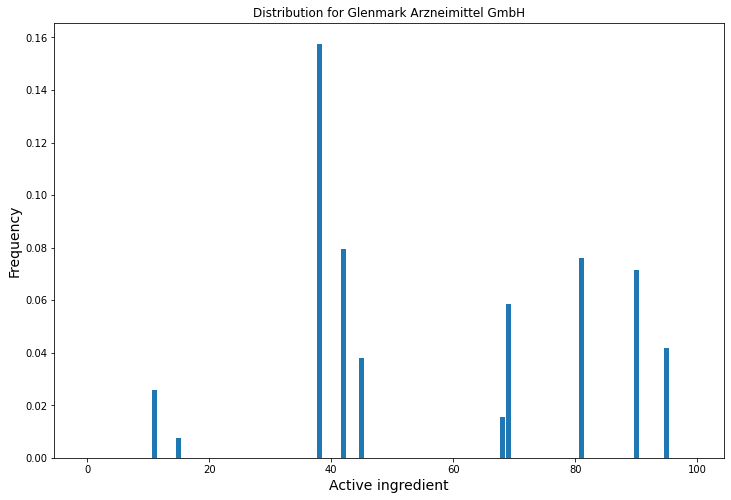

Company Hexal Aktiengesellschaft


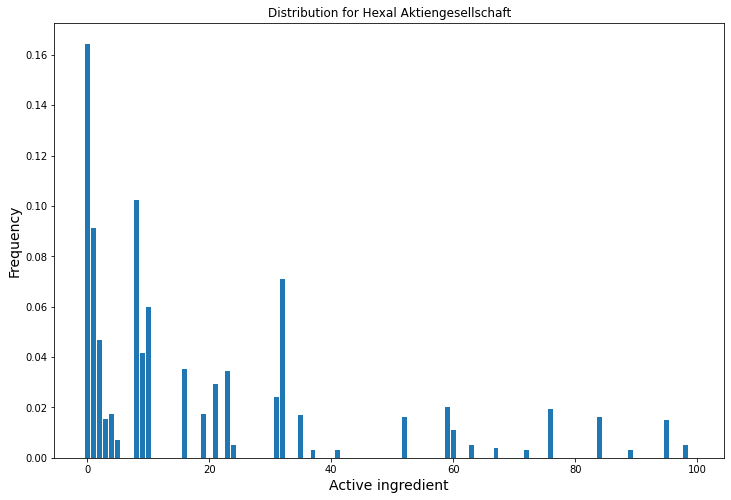

Company ratiopharm GmbH


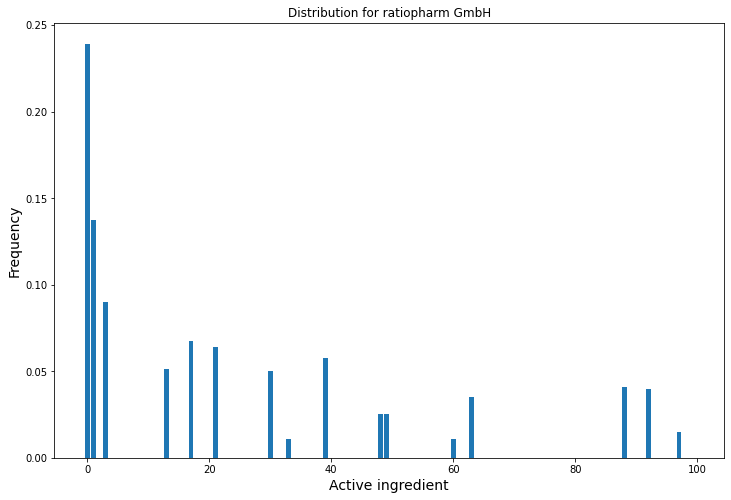

Company 1 A Pharma GmbH


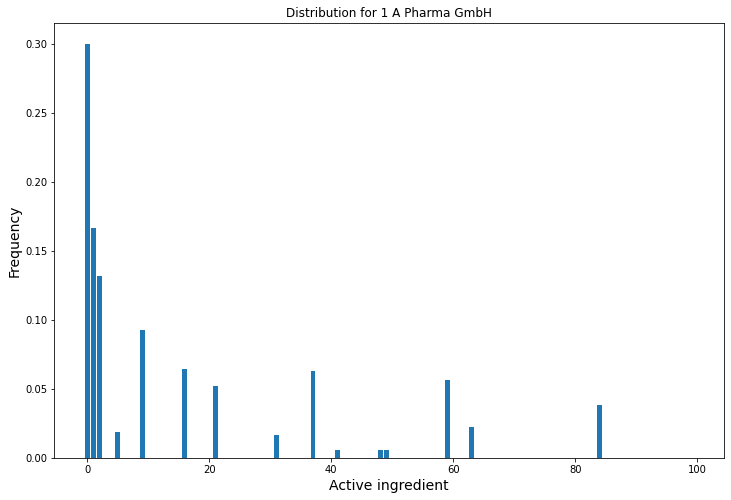

Company ALIUD PHARMA GmbH


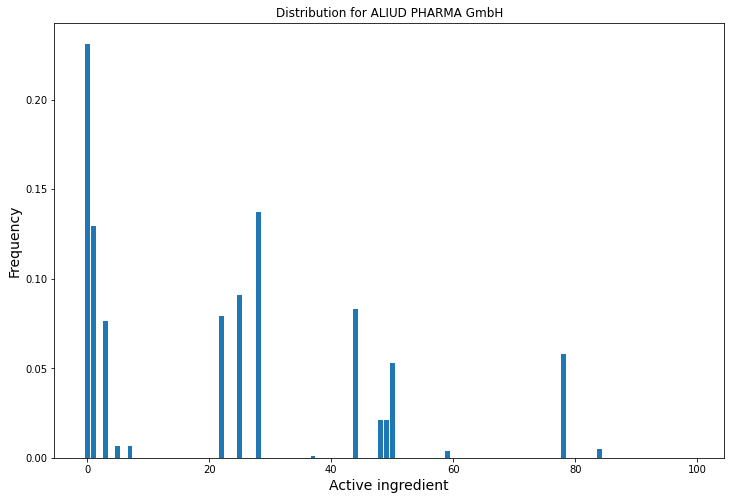

Company Merck Serono GmbH


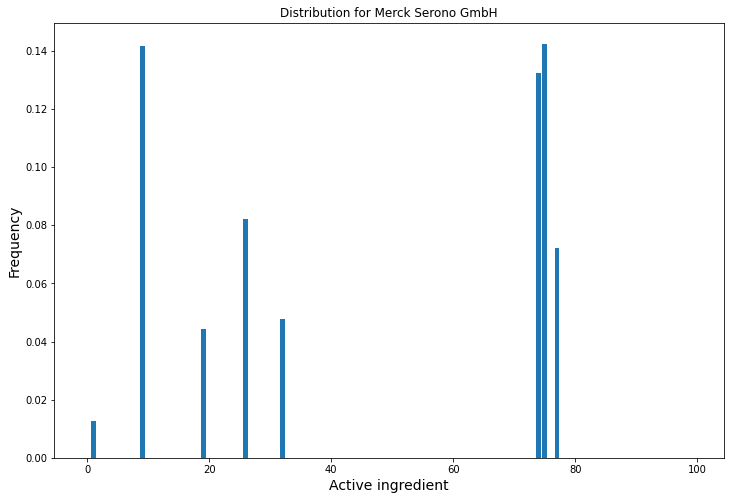

Company Pfizer Pharma PFE GmbH


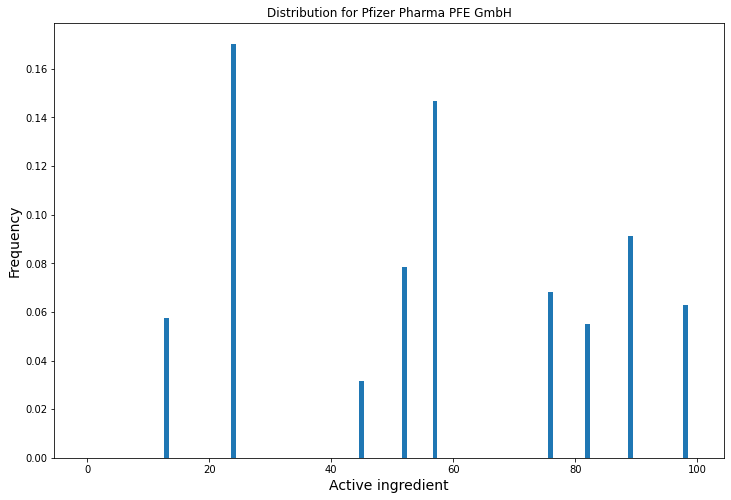

Company PUREN Pharma GmbH & Co. KG


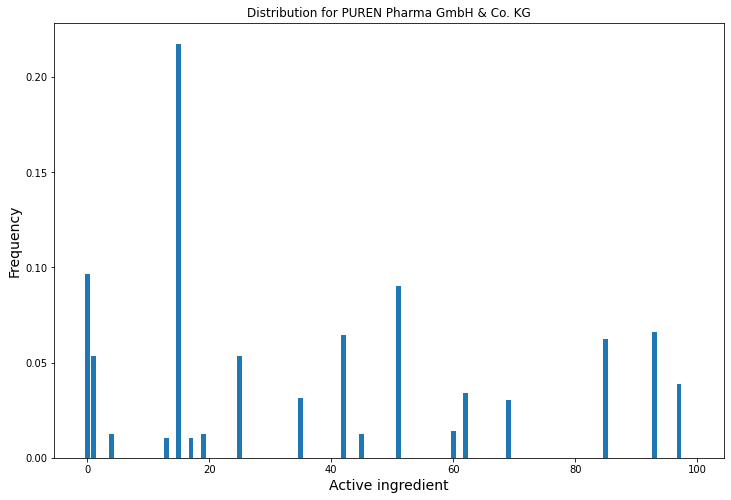

Company TEVA GmbH


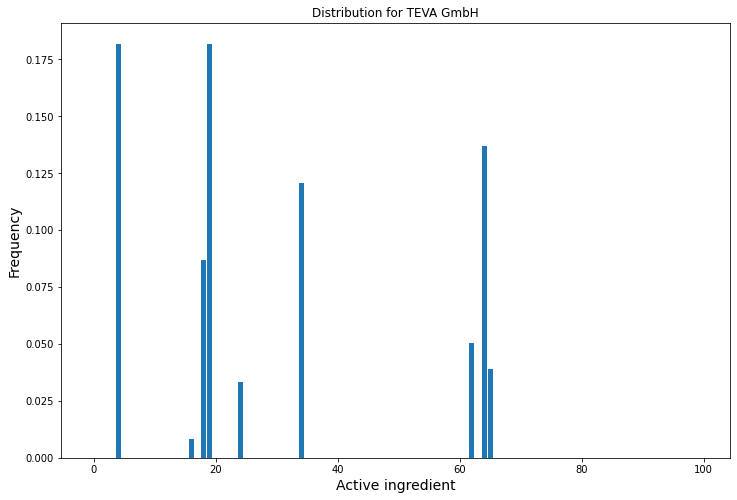

Company STADAPHARM, Gesellschaft mit beschr�nkter Haftung


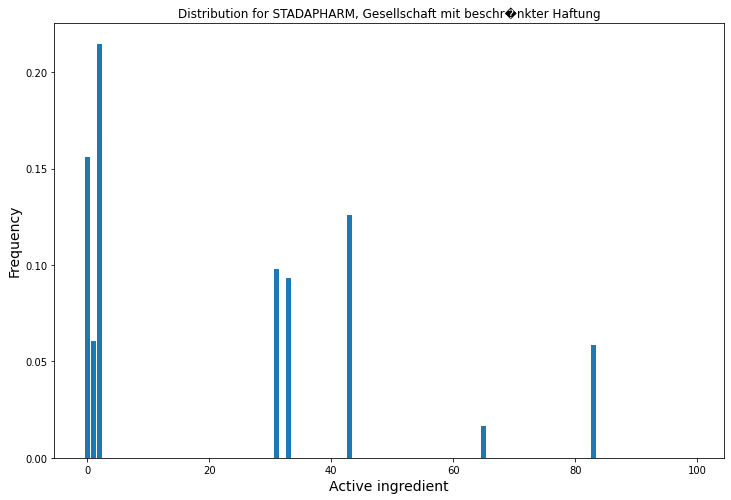

Company Sanofi-Aventis Deutschland GmbH


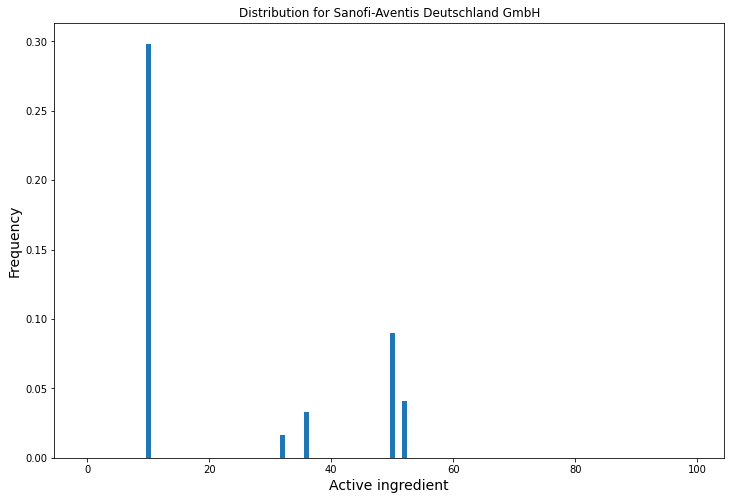

Company Aspen Pharma Trading Limited


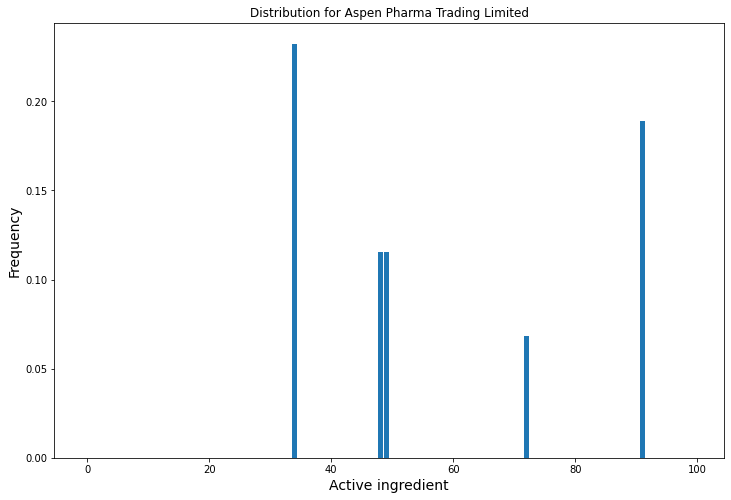

Company AbZ-Pharma GmbH - Gesch�ftsanschrift -


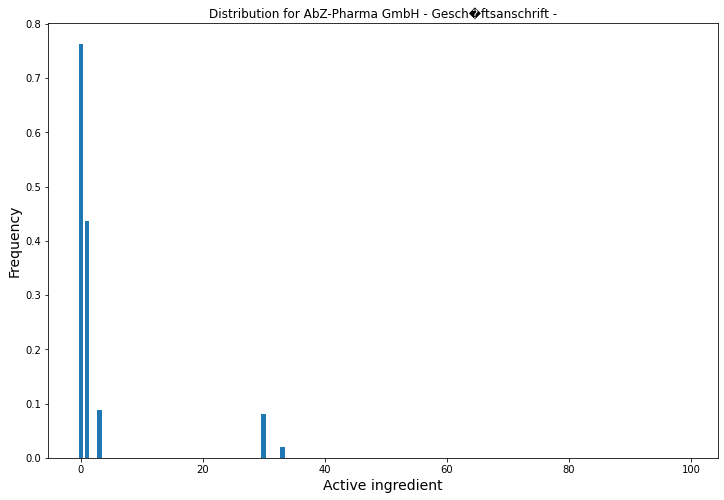

Company Fresenius Kabi Deutschland GmbH


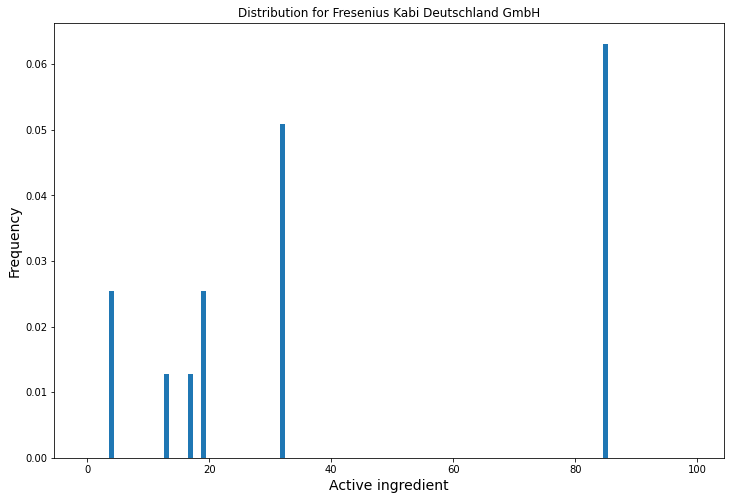

Company Winthrop Arzneimittel GmbH


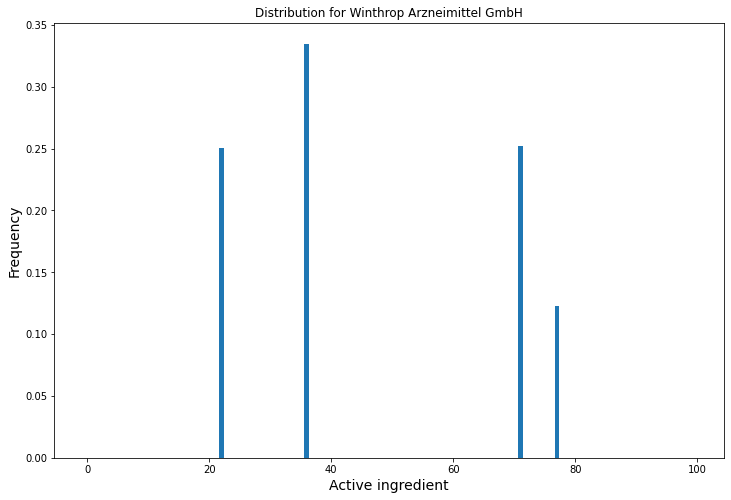

Company Hennig Arzneimittel GmbH & Co KG


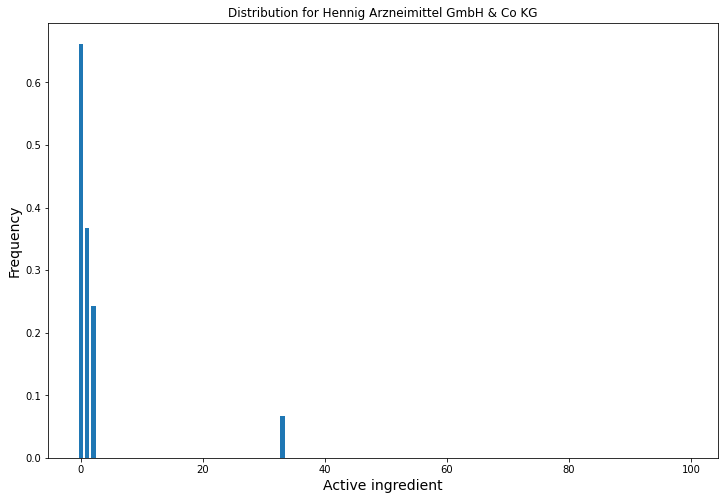

Company B. Braun Melsungen Aktiengesellschaft


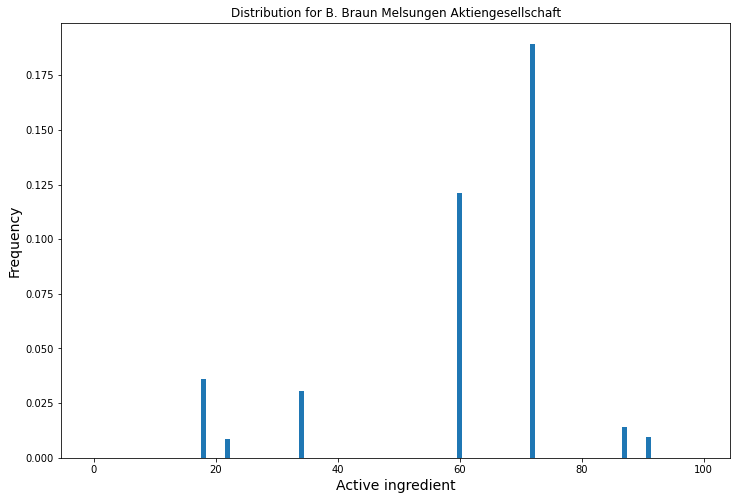

Company Galderma Laboratorium GmbH


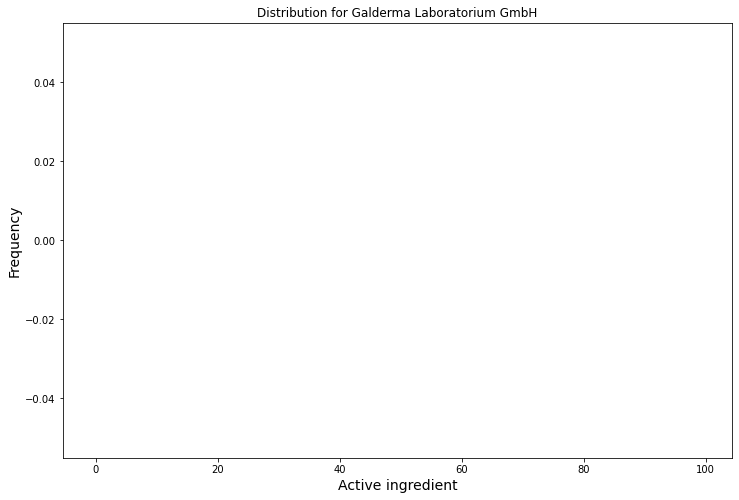

Company Zentiva Pharma GmbH


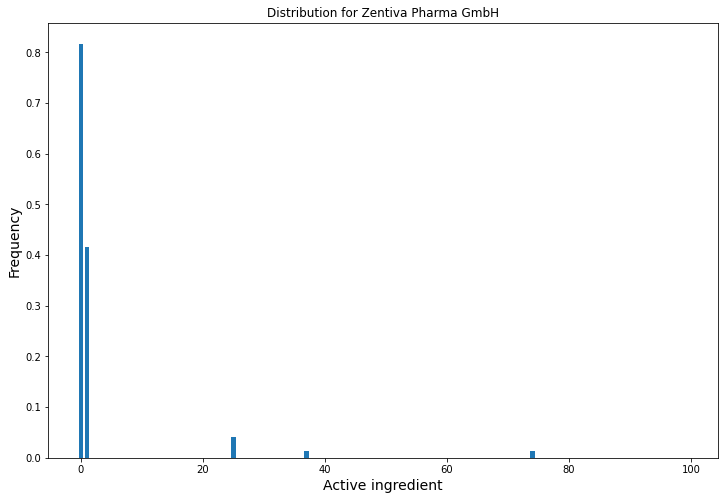

In [51]:
for comp, val in df['Zulassungsinhaber'].value_counts().items():
    if val > 20:
        print("Company", comp)
        plot_wirkstoff_distr_per_company(df, comp, top_ingredients_days, top=100)

In [104]:
def plot_bars_side_by_side(vals1, vals2, comp1, comp2, top_ingredients, top):
    distr1 = [vals1.get(w, 0) for w in top_ingredients[:top]]
    distr2 = [vals2.get(w, 0) for w in top_ingredients[:top]]
    
    plt.figure(figsize=(12, 8))
    k = 4
    plt.bar([k*i for i in list(range(top))], distr1, label=comp1)
    plt.bar([k*i+1 for i in list(range(top))], distr2, label=comp2)
    plt.title("Distribution for {} and {}".format(comp1, comp2))
    plt.xlabel("Active ingredient", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    # plt.xticks([i for i in range(0, k*top+1, 100)], [i//k for i in range(0, k*top+1, 100)])
    plt.legend(loc='best', fontsize=13)
    if top <=15:
        x_labels = top_ingredients[:top]
        plt.xticks([k*i + 0.5 for i in range(0, top)], x_labels, fontsize=14, rotation=90)
    plt.show()
    

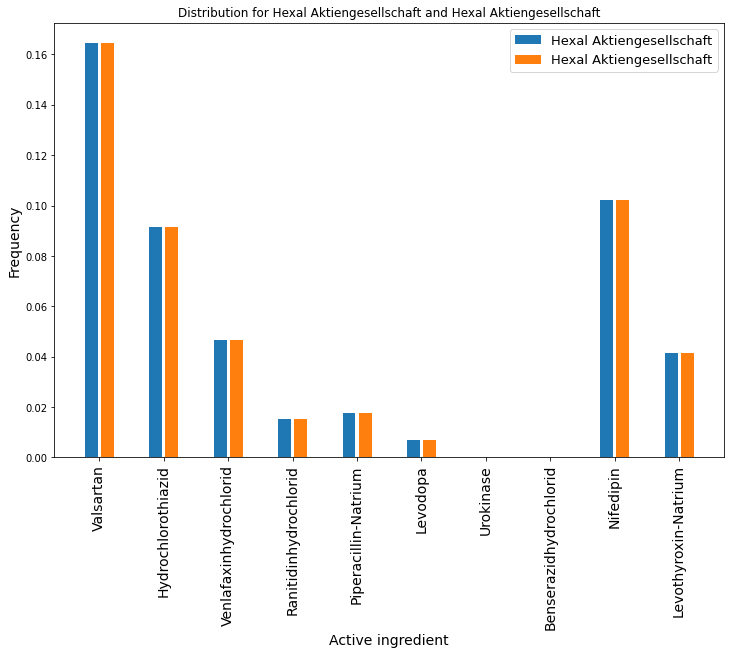

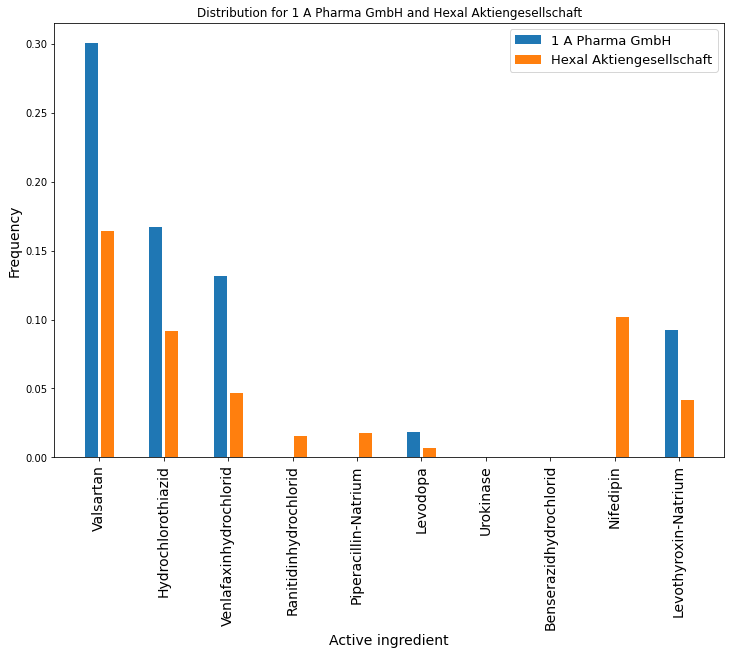

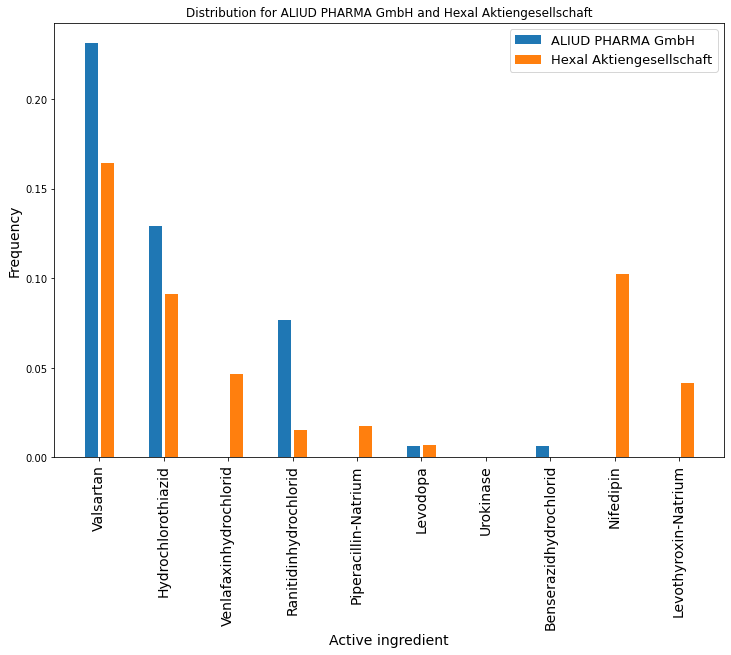

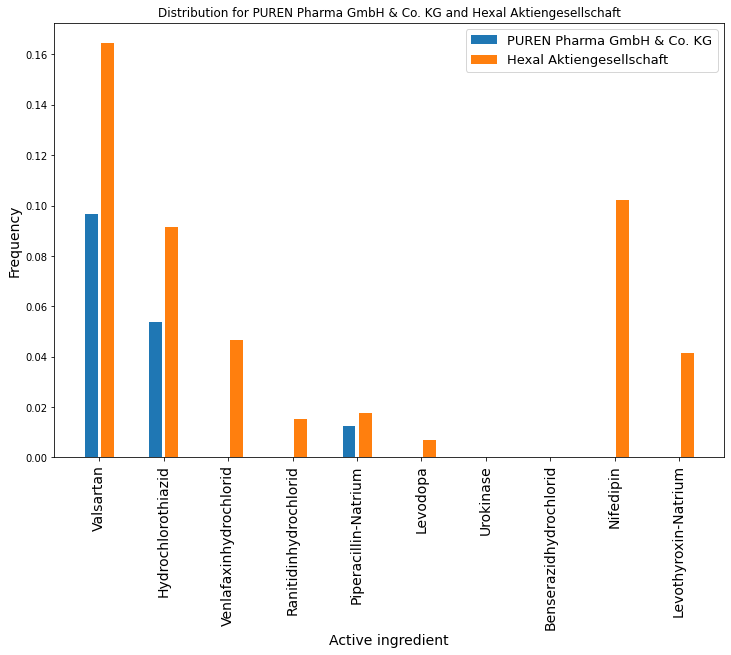

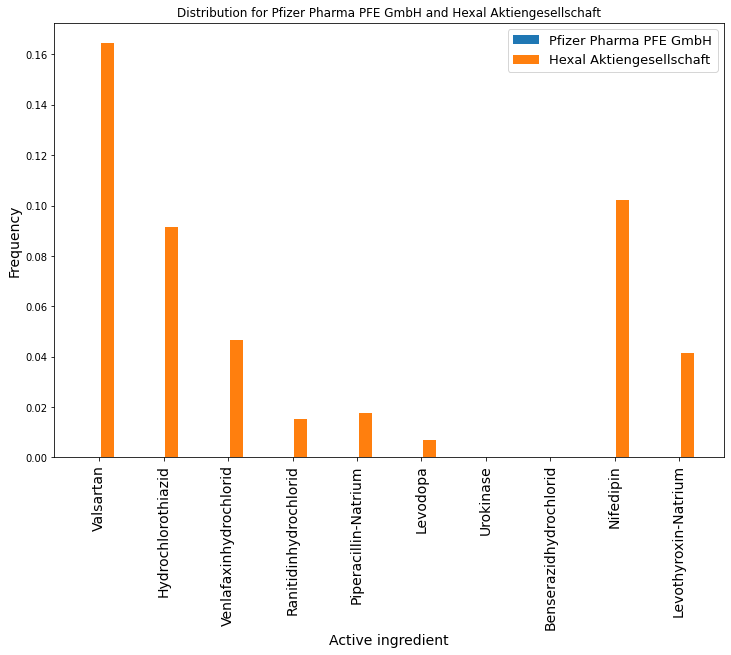

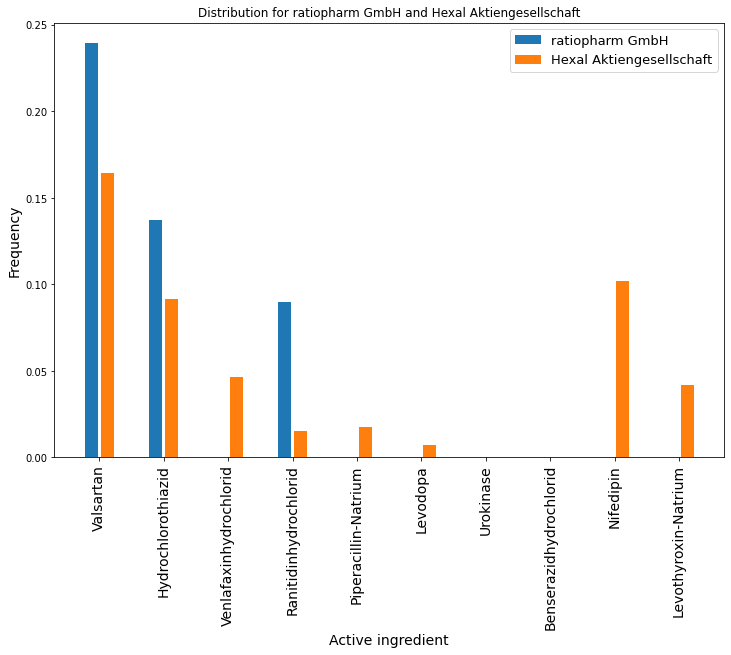

In [107]:
# n1 = '1 A Pharma GmbH' 
# n1 = 'ratiopharm GmbH'
n2 = 'Hexal Aktiengesellschaft' 
# n2 = 'TEVA GmbH'
for n1 in df['Zulassungsinhaber'].unique():
    vals1 = plot_wirkstoff_distr_per_company(df, n1, top_ingredients_days, top=100, plotit=False)
    vals2 = plot_wirkstoff_distr_per_company(df, n2, top_ingredients_days, top=100, plotit=False)
    if len(set(vals1.keys()).intersection(vals2.keys())) > 5:
        plot_bars_side_by_side(vals1, vals2, n1, n2, top_ingredients_days, top=10)

In [38]:
def plot_wirkstoff_distr_per_year(df, top_ingredients, year, top):
    vals = {}
    for ws, years_dict in zip(df['wirkstoff'], df['years']):
        for w in ws:
            vals.setdefault(w, 0)
            vals[w] += years_dict.get(str(year), 0) #df['Zulassungsinhaber'].nunique()
    distr_vals = [vals.get(w, 0) for w in top_ingredients[:top]]
    print("sum", sum(distr_vals))
    plt.figure(figsize=(12, 8))
    plt.bar(list(range(len(distr_vals))), distr_vals, log=True)
    plt.title("Distribution for year " + str(year), fontsize=16)
    plt.xlabel("Active ingredient", fontsize=14)
    # plt.ylim([0,36000])
    plt.ylabel("Frequency", fontsize=14)
    if top <=15:
        x_labels = top_ingredients[:top]
        plt.xticks(range(top), x_labels, fontsize=16, rotation=90)
    plt.show()    

sum 47533


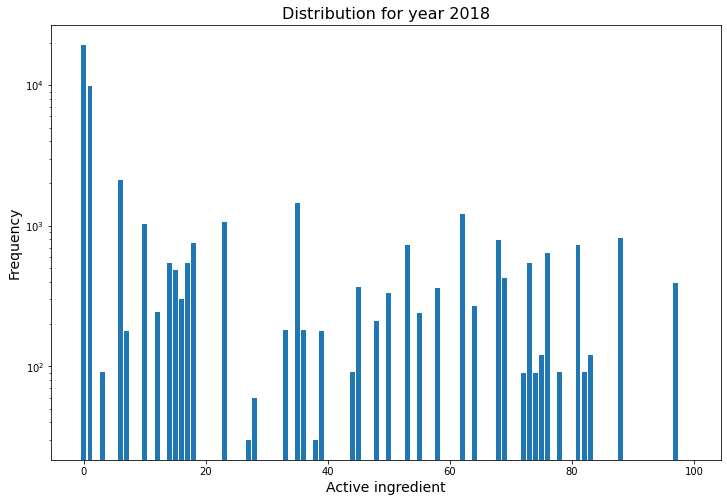

sum 93753


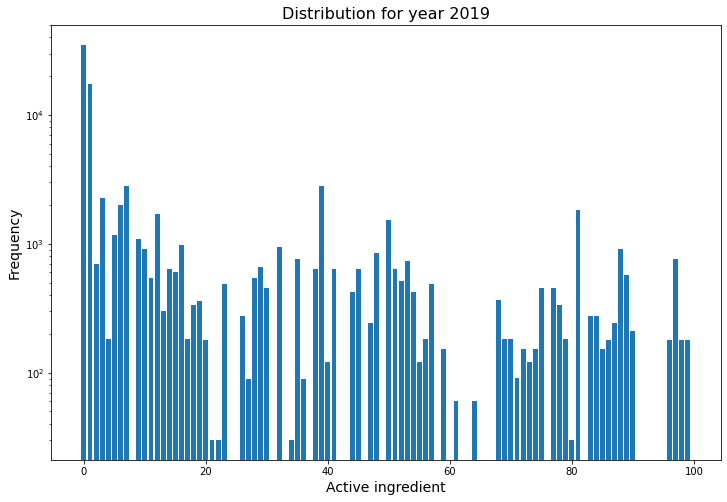

sum 112033


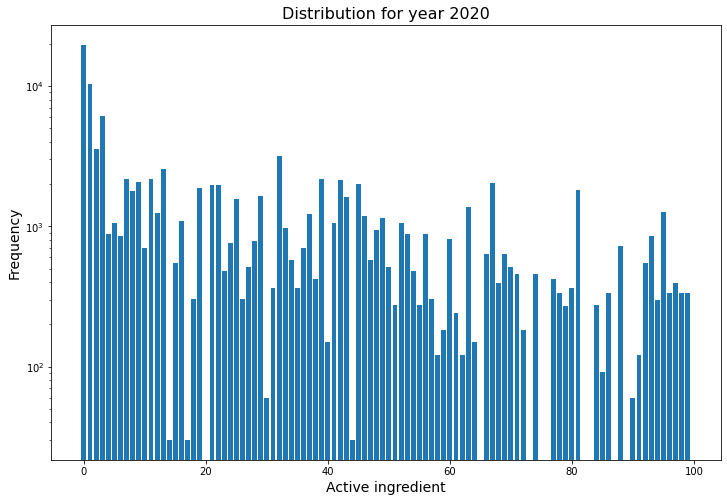

sum 48971


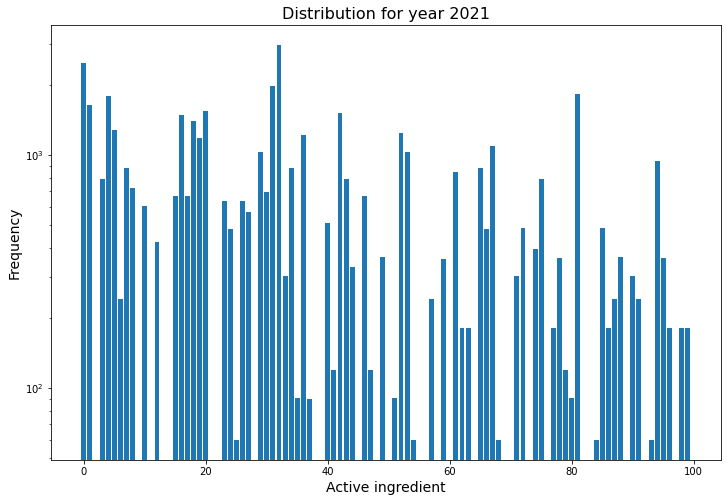

In [39]:
for year in [2018,2019,2020,2021]:
    plot_wirkstoff_distr_per_year(df, top_ingredients_reports, year, top=100)

In [40]:
def top_wirkstoffe_per_company_per_year(df, company, year, top, plotit=True):
    vals = {}
    df_comp = df[df["Zulassungsinhaber"]==company]
    for ws, years_dict in zip(df_comp['wirkstoff'], df_comp['years']):
        for w in ws:
            vals.setdefault(w, 0)
            vals[w] += years_dict.get(str(year), 0) # days/sum(df_comp['days'])
    nnz = 0
    for k, v in vals.items():
        if v > 0:
            nnz += 1
    top_vals = sorted([(v,k) for k, v in vals.items()], reverse=True)[:min(top, nnz)]
    top_ingredients = [v[1] for v in top_vals]
    if plotit:
        plt.figure(figsize=(12, 8))
        plt.bar(list(range(len(top_vals))), [v[0] for v in top_vals])
        plt.title("Distribution for " + company + " for year " + str(year), fontsize=15)
        plt.xlabel("Active ingredient", fontsize=14)
        plt.ylabel("Frequency", fontsize=14)
        if top <=15:
            x_labels = top_ingredients[:len(top_vals)]
            plt.xticks(range(len(top_vals)), x_labels, fontsize=14, rotation=90)
        plt.show()
    #print(vals)
    return vals

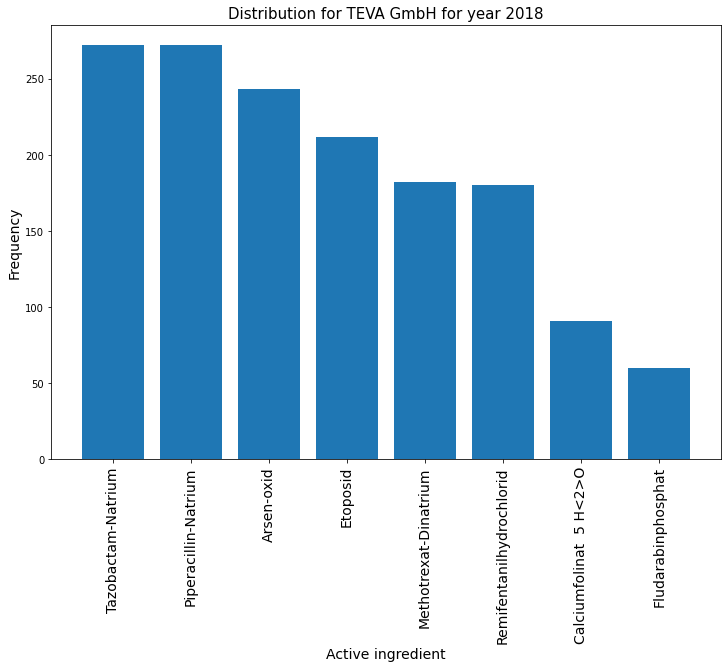

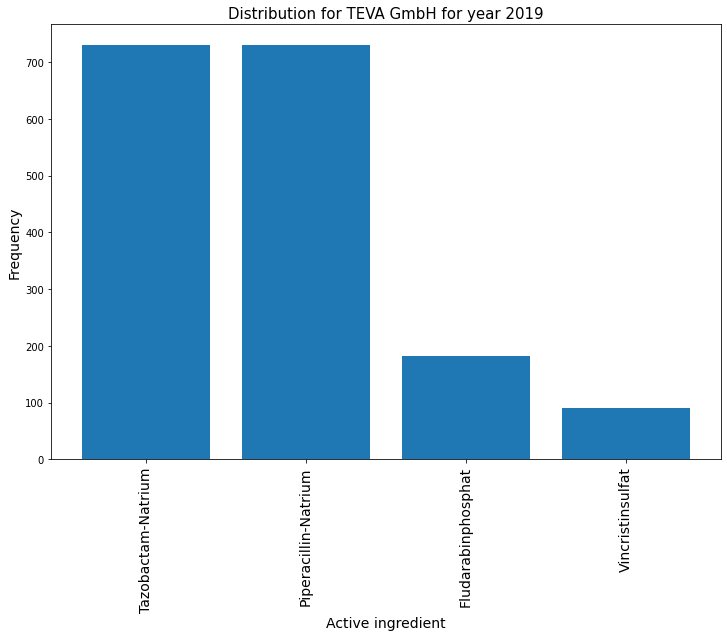

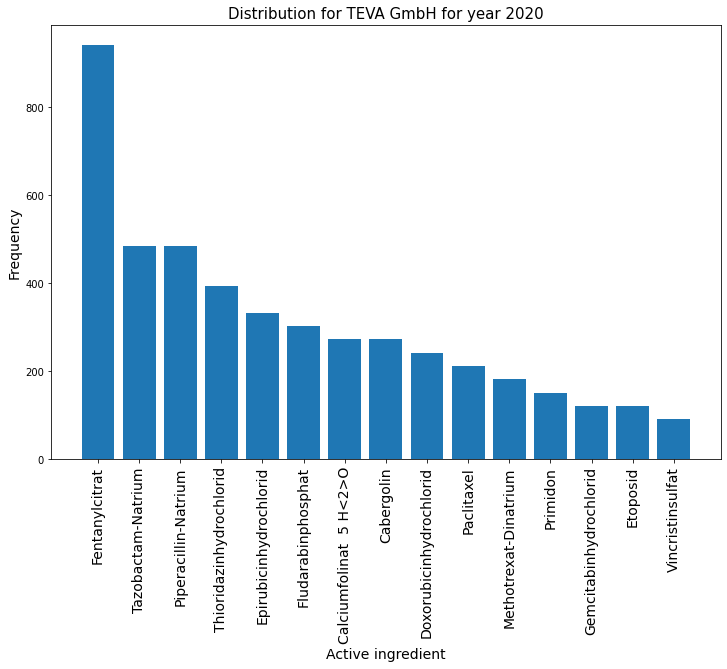

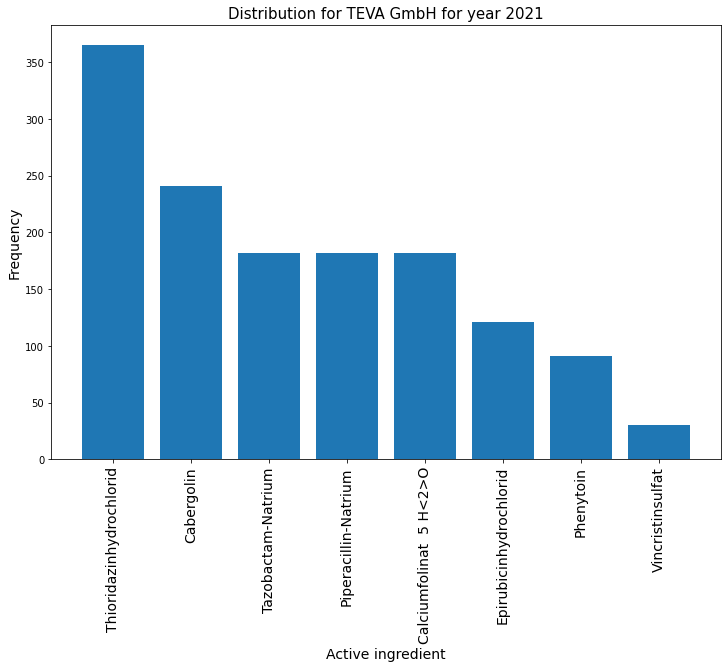

In [41]:
for year in [2018, 2019, 2020, 2021]:
    top_wirkstoffe_per_company_per_year(df, 'TEVA GmbH', year, top=15, plotit=True)

## Compare distributions

In [42]:
def map2vec(distr, top_ingredients):
    s = sum(distr.values())
    v = []
    for t in top_ingredients:
        v.append(distr.get(t, 0))
    return v

In [43]:
def cosine(v1, v2):
    return np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))    

In [44]:
t19 = map2vec(top_wirkstoffe_per_company_per_year(df, 'TEVA GmbH', 2019, top=200, plotit=False), 
              top_ingredients_reports)
t20 = map2vec(top_wirkstoffe_per_company_per_year(df, 'TEVA GmbH', 2020, top=200, plotit=False), 
              top_ingredients_reports)

In [45]:
pearsonr(t19, t20)

(0.5361285651705876, 2.8070940865205206e-16)

In [46]:
d1 = top_wirkstoffe_per_company_per_year(df, 'TEVA GmbH', 2019, top=200, plotit=False)
d2 = top_wirkstoffe_per_company_per_year(df, 'TEVA GmbH', 2020, top=200, plotit=False)
compare_distr(d1, d2)

Pearson correlation: (0.3803978357948528, 0.0980189804134622)


In [47]:
vecs = []
comps = []
for comp in df['Zulassungsinhaber'].unique():
    v = map2vec(plot_wirkstoff_distr_per_company(df, comp, top_ingredients_reports, top = 100, 
                                                 normalize=False,plotit = False), 
                top_ingredients_reports)
    if sum(v) > 10 and np.count_nonzero(v) >= 6:
        vecs.append(v)
        comps.append(comp)
print(len(vecs))    

18


Hexal Aktiengesellschaft  :  1 A Pharma GmbH (0.7593306509410677, 8.338822869515372e-39)


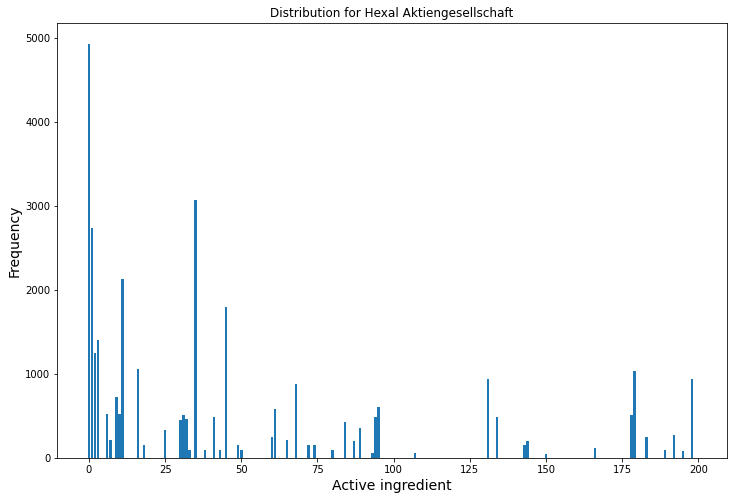

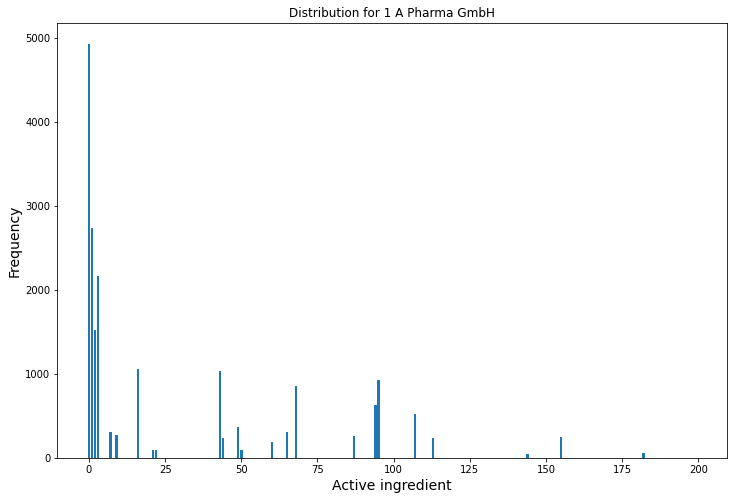



1 A Pharma GmbH  :  AbZ-Pharma GmbH - Gesch�ftsanschrift - (0.8433397743369354, 2.642586885418987e-55)


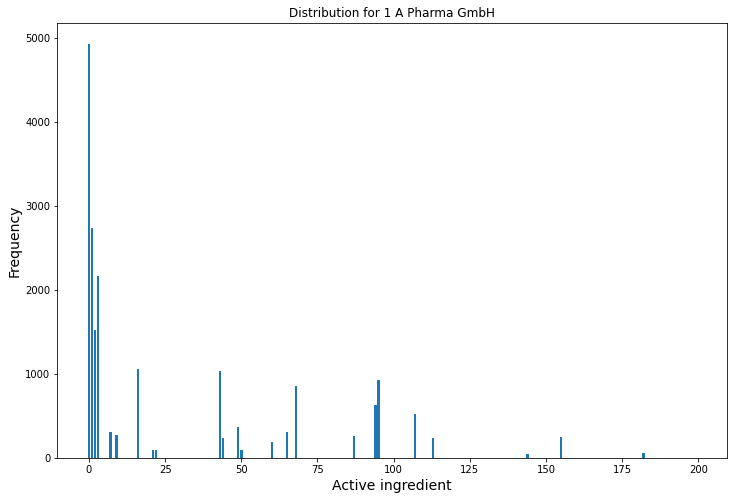

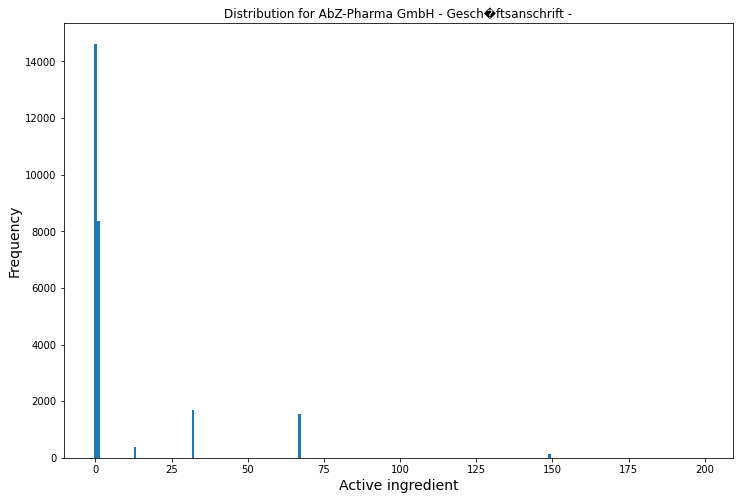



1 A Pharma GmbH  :  Zentiva Pharma GmbH (0.8491586281673866, 8.456756239513747e-57)


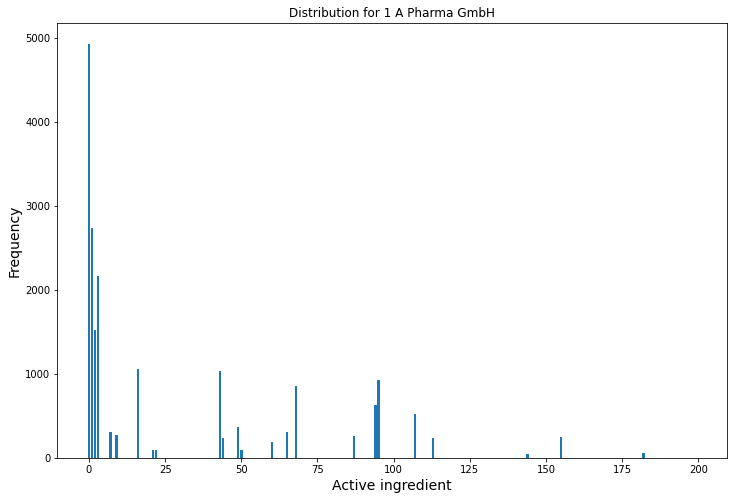

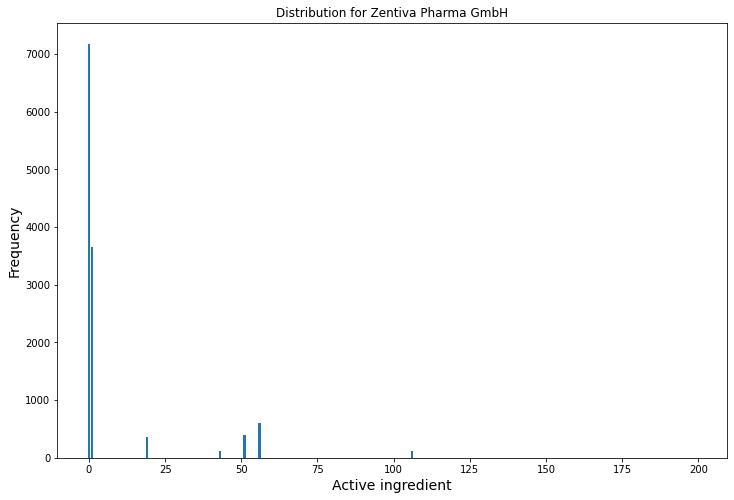



ALIUD PHARMA GmbH  :  AbZ-Pharma GmbH - Gesch�ftsanschrift - (0.7730224678909979, 5.350943105834461e-41)


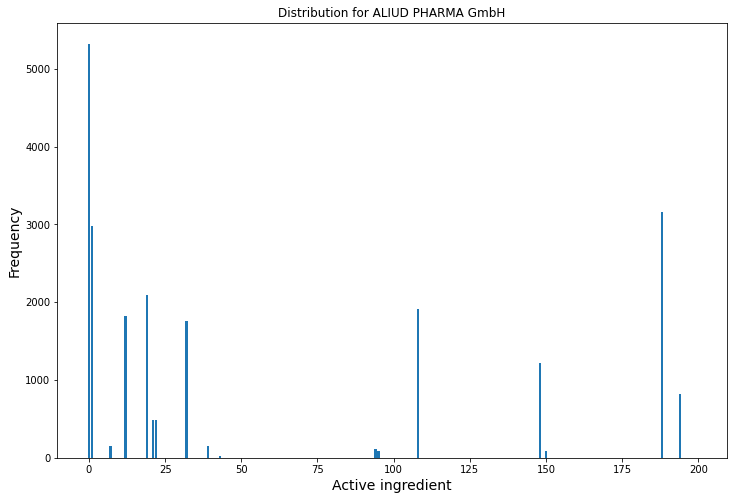

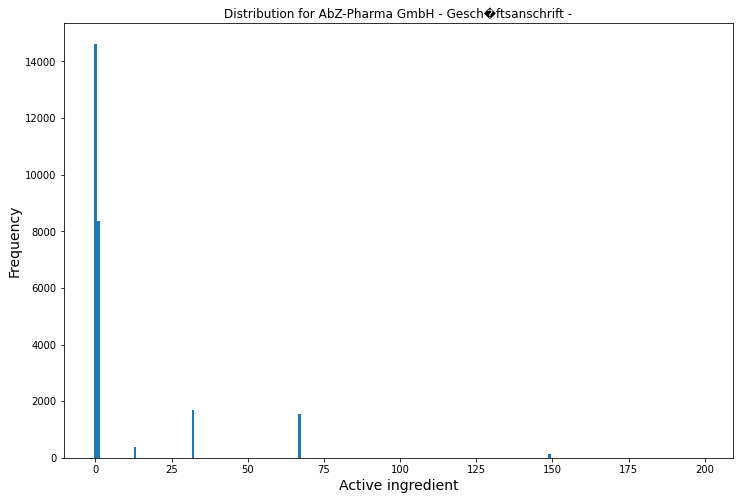



ALIUD PHARMA GmbH  :  Zentiva Pharma GmbH (0.7654513605466213, 9.107493563868693e-40)


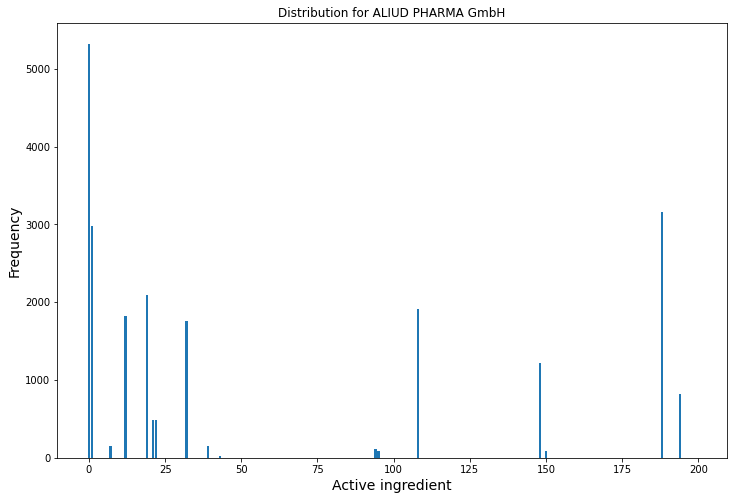

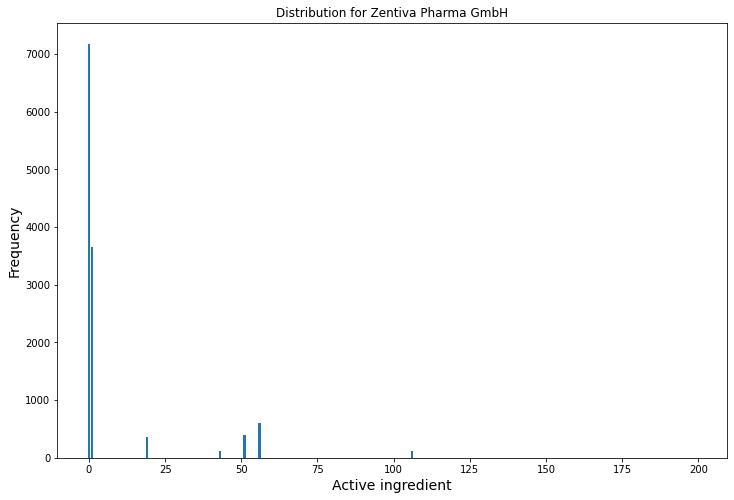



ratiopharm GmbH  :  AbZ-Pharma GmbH - Gesch�ftsanschrift - (0.8729024326001035, 1.2589383076217594e-63)


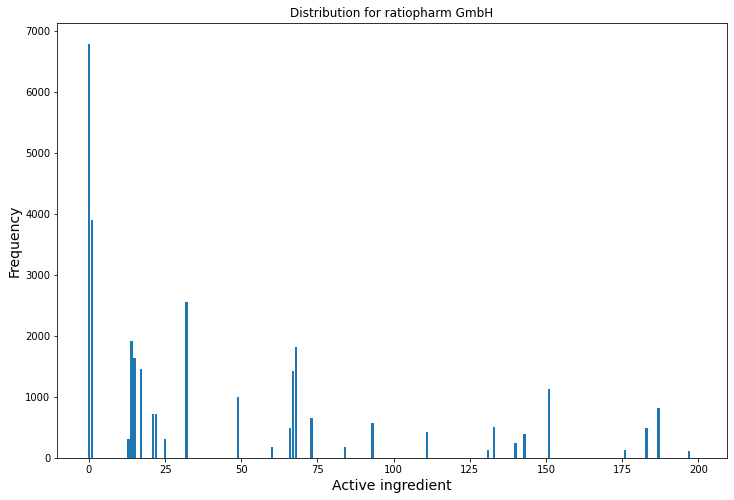

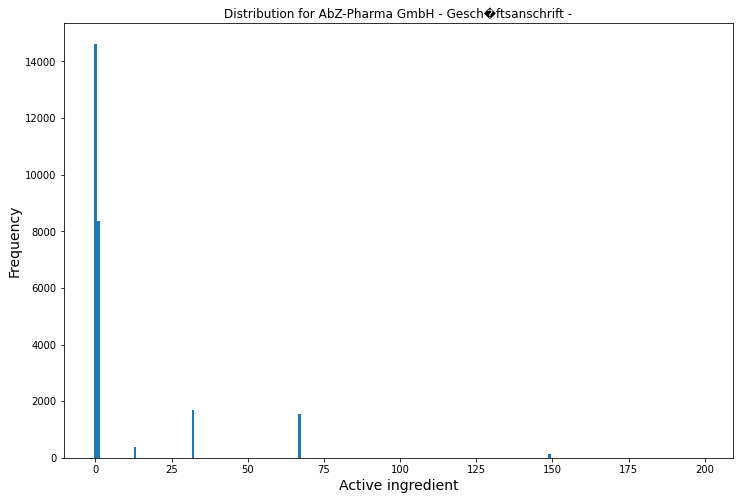



ratiopharm GmbH  :  Zentiva Pharma GmbH (0.8325091307684989, 1.1179046450866391e-52)


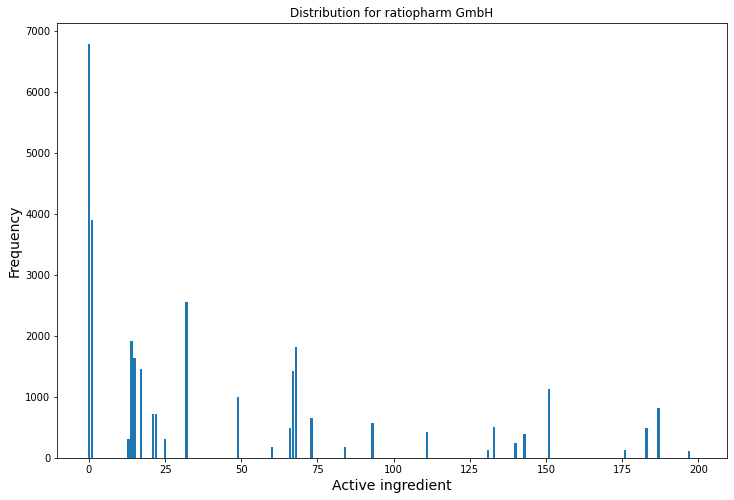

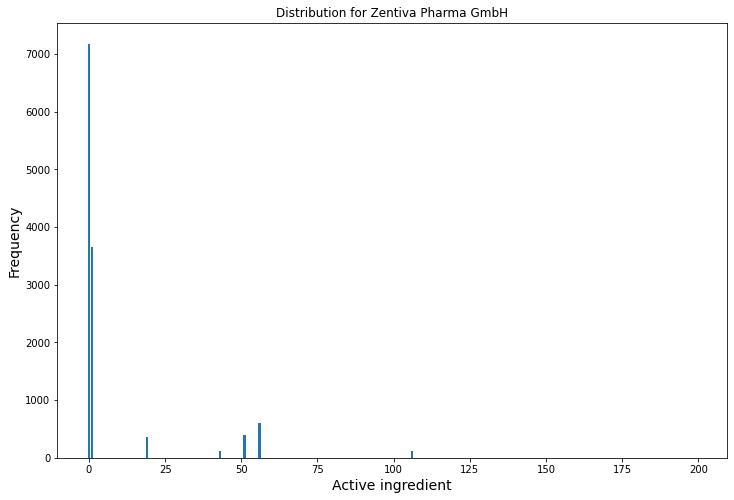



AbZ-Pharma GmbH - Gesch�ftsanschrift -  :  Zentiva Pharma GmbH (0.9839934573340858, 2.766528600707265e-150)


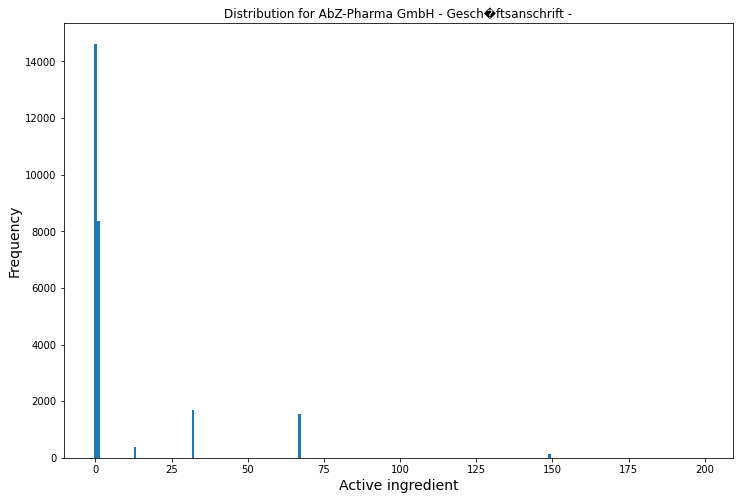

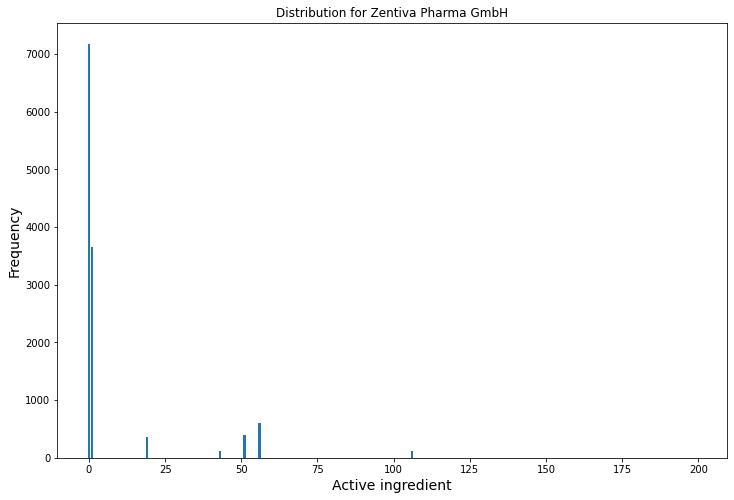

In [48]:
for i in range(len(vecs)):
    for j in range(i+1, len(vecs)):
        p = pearsonr(vecs[i], vecs[j])
        if p[0] > 0.75:
            print(comps[i], " : ",  comps[j], p)
            plot_wirkstoff_distr_per_company(df=df, company=comps[i], top_ingredients=top_ingredients_reports,
                                             normalize=False, plotit=True, top=200)
            plot_wirkstoff_distr_per_company(df=df, company=comps[j], top_ingredients=top_ingredients_reports,
                                             normalize=False, plotit=True, top=200)
            print("\n")

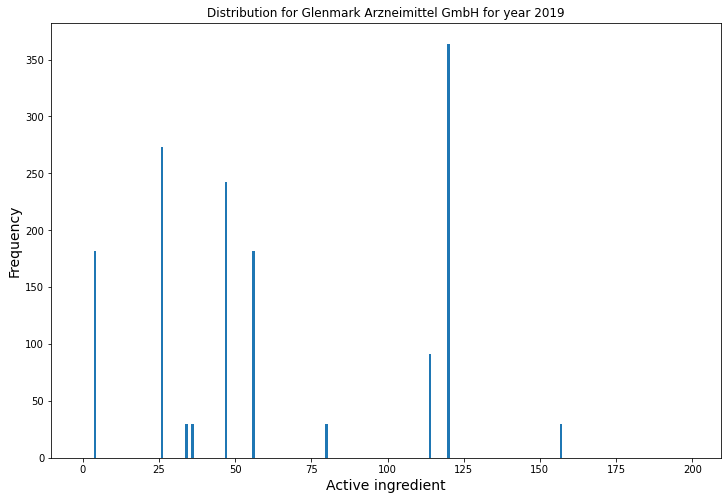

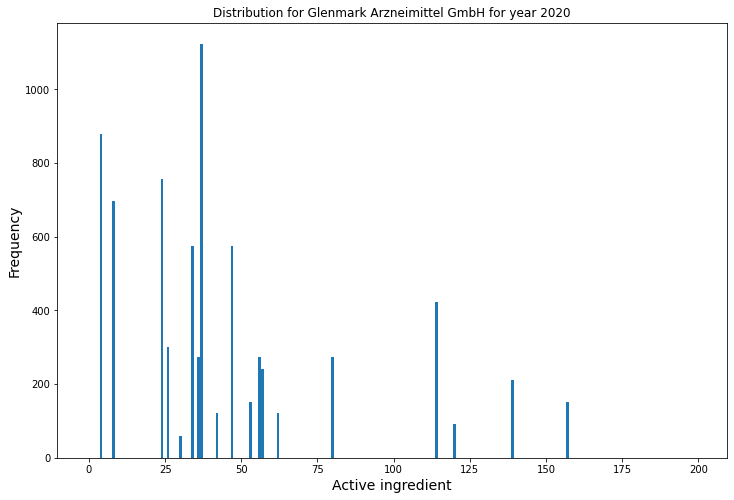

Glenmark Arzneimittel GmbH (0.4137079759711039, 1.135823666566203e-09)




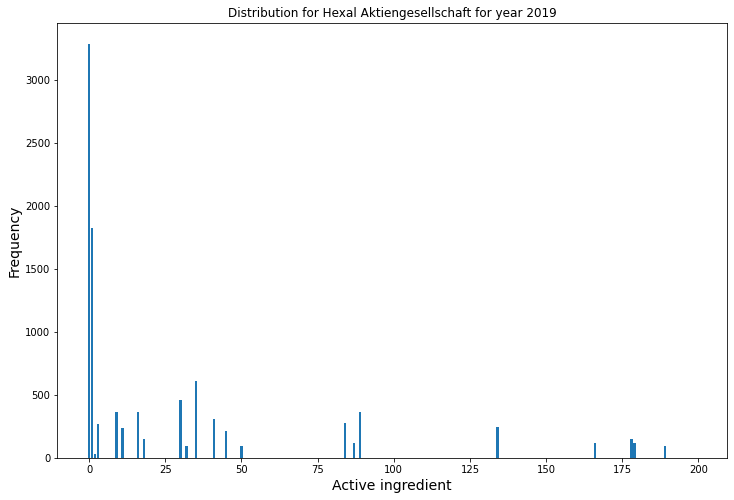

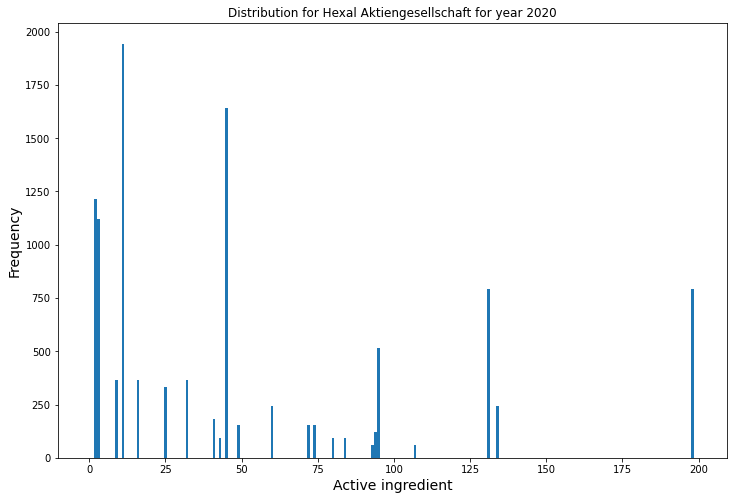

Hexal Aktiengesellschaft (0.08173345321646609, 0.2499106065147158)




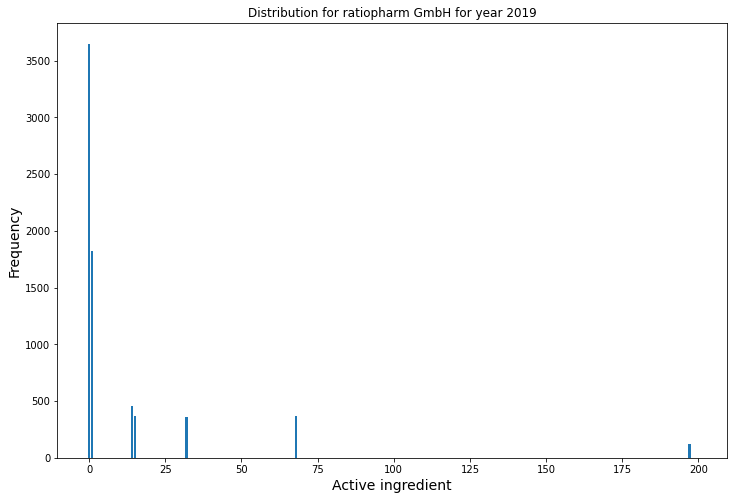

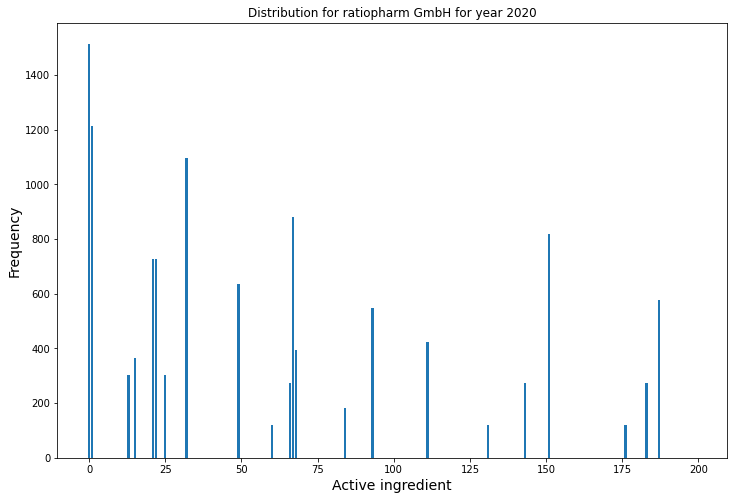

ratiopharm GmbH (0.654974861240046, 6.943239191585731e-26)




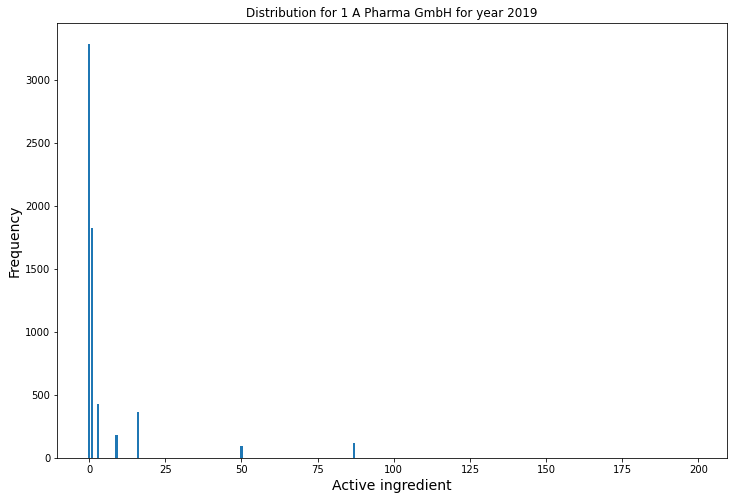

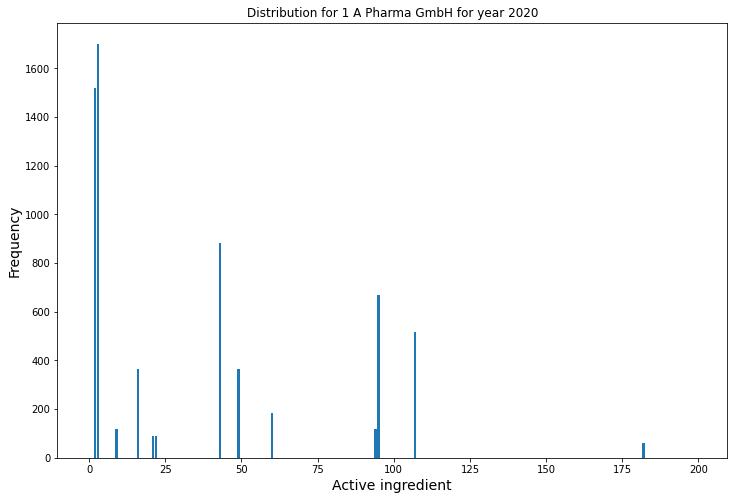

1 A Pharma GmbH (0.06753390359604107, 0.34202463035882646)




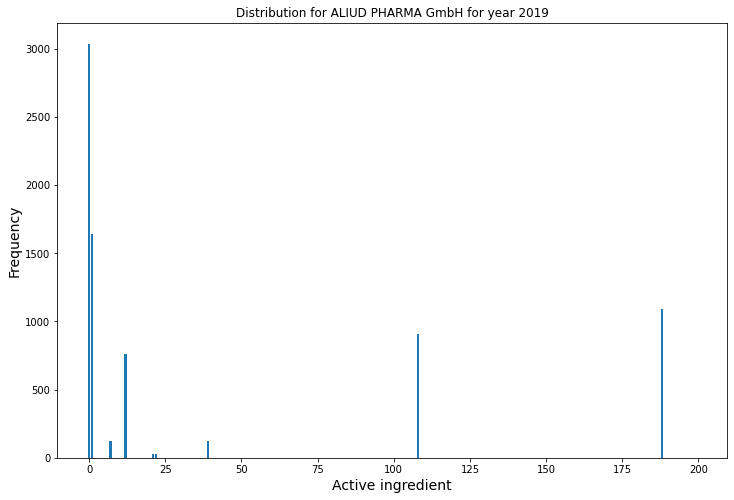

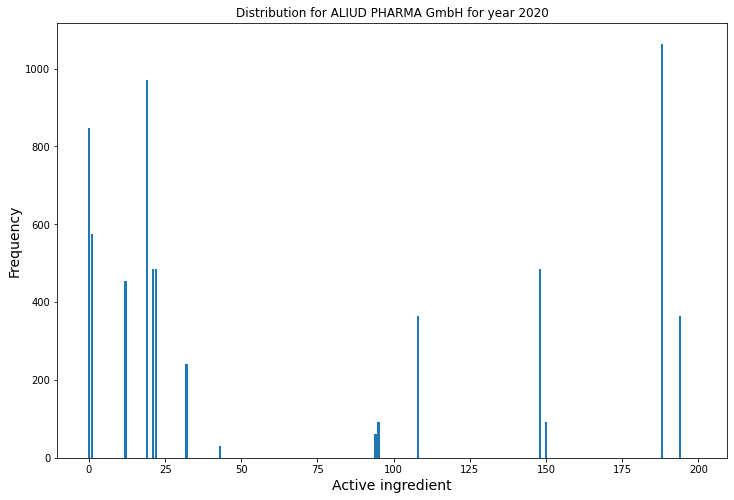

ALIUD PHARMA GmbH (0.6662340766170922, 5.004666051873639e-27)




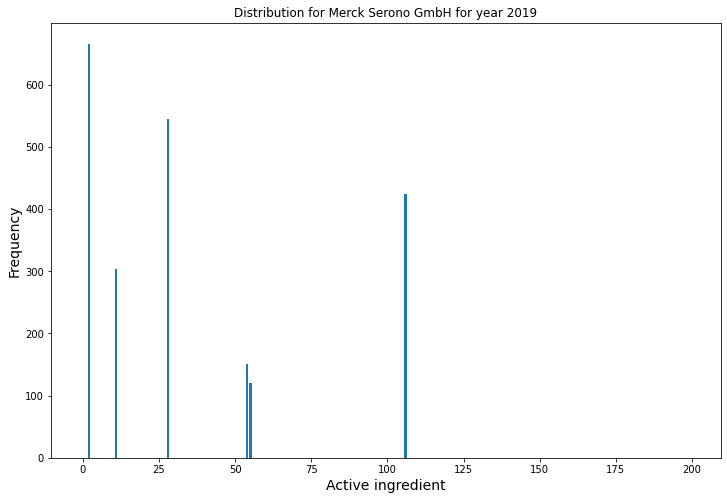

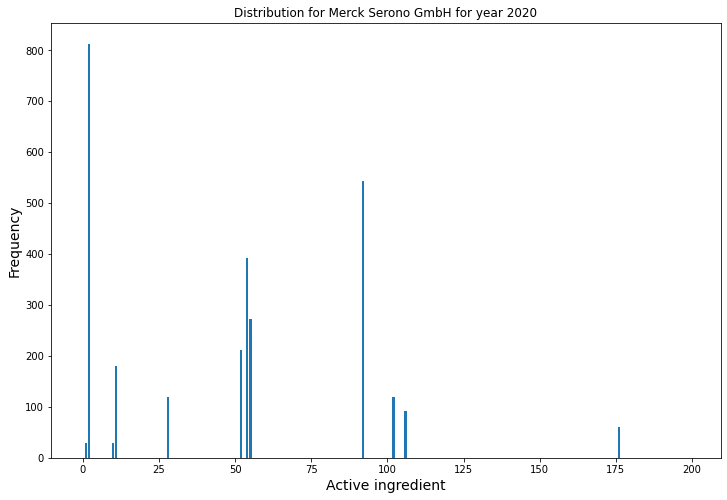

Merck Serono GmbH (0.6681684881611779, 3.148597276159516e-27)




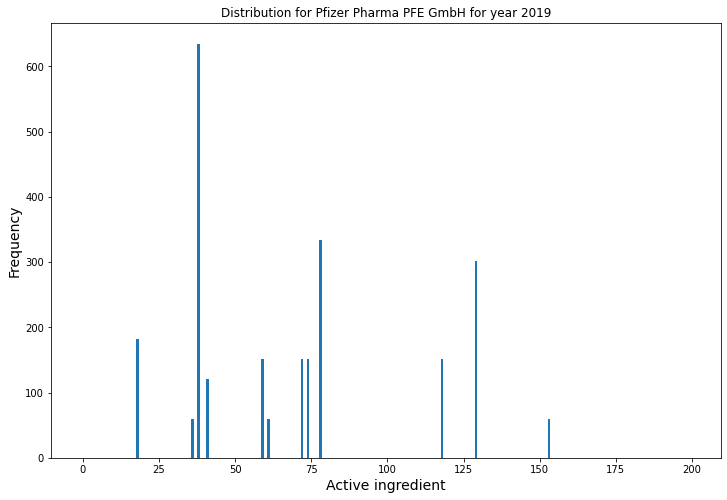

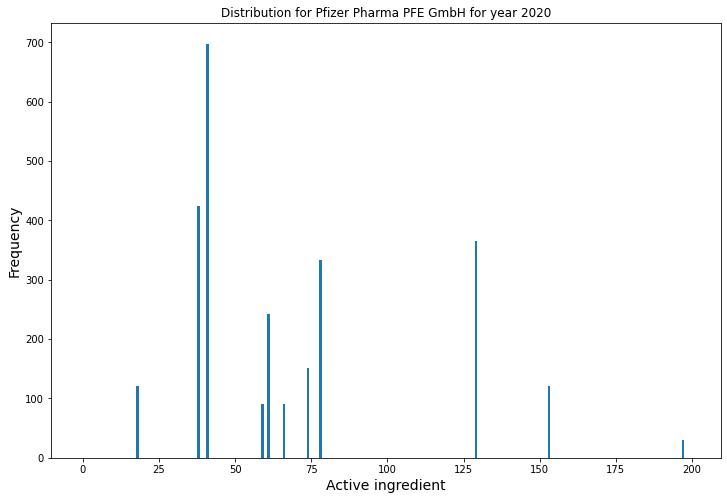

Pfizer Pharma PFE GmbH (0.7299740929171, 1.4552127686953186e-34)




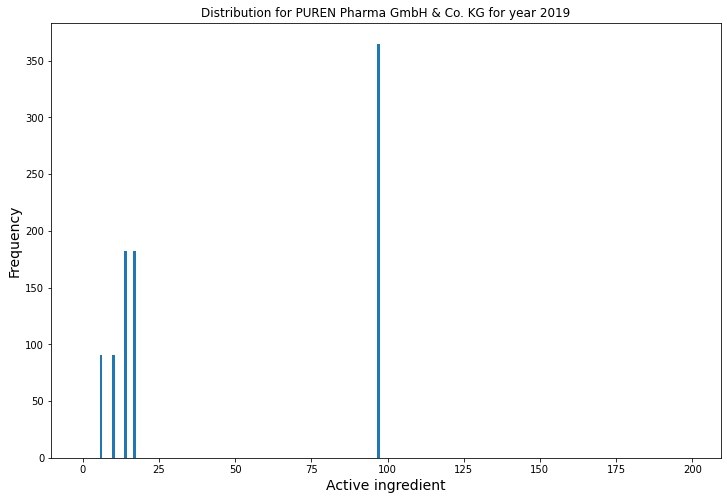

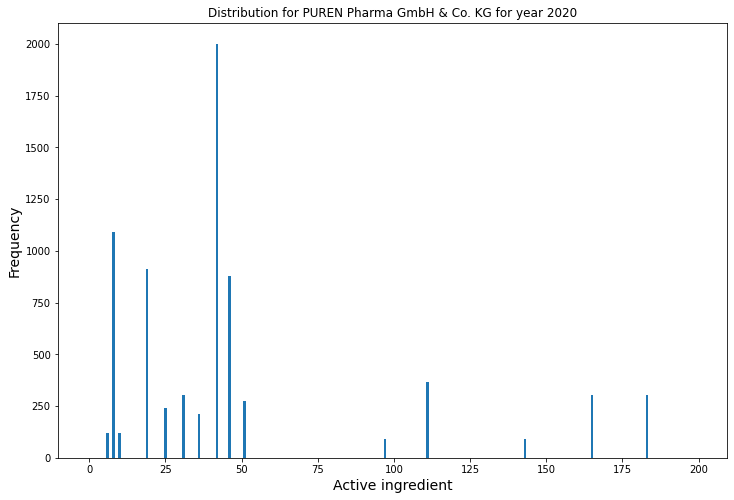

PUREN Pharma GmbH & Co. KG (0.01779419205092119, 0.802517486457465)




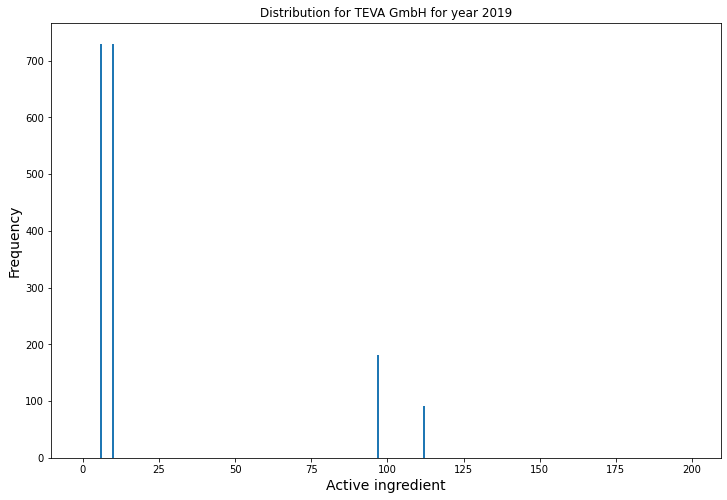

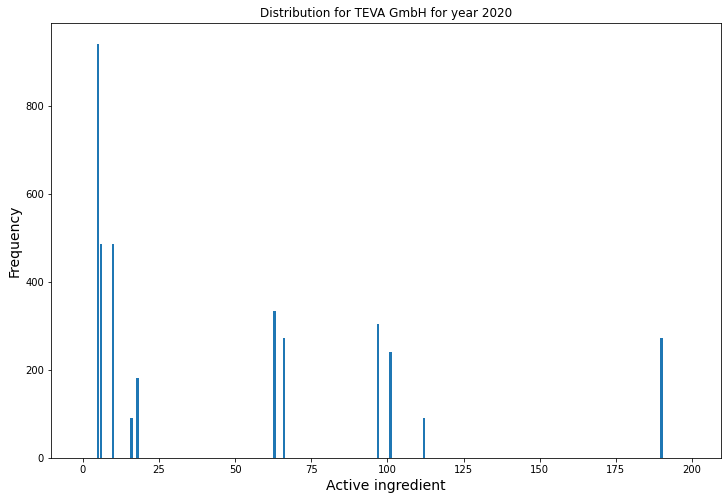

TEVA GmbH (0.5361285651705876, 2.8070940865205206e-16)




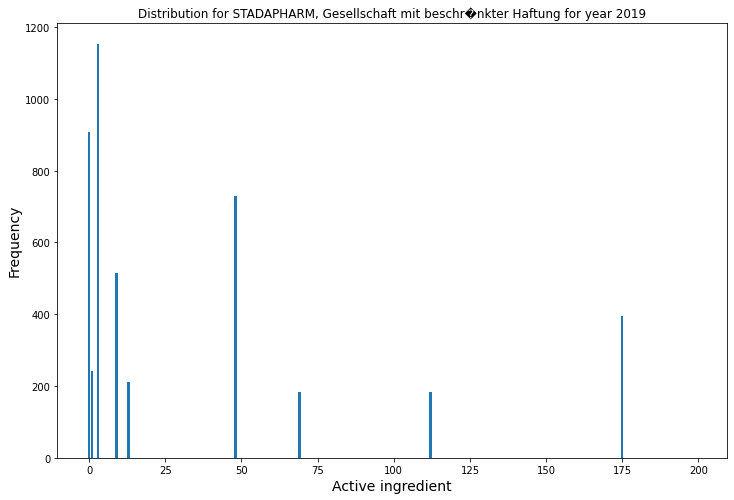

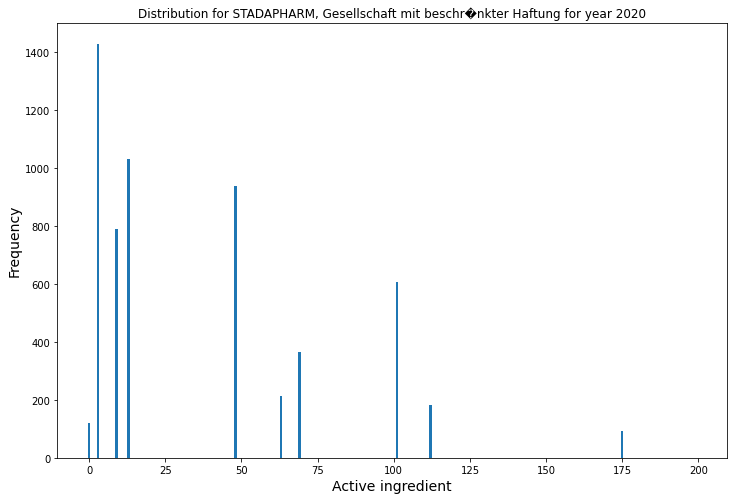

STADAPHARM, Gesellschaft mit beschr�nkter Haftung (0.7669688669807976, 5.204942055208323e-40)




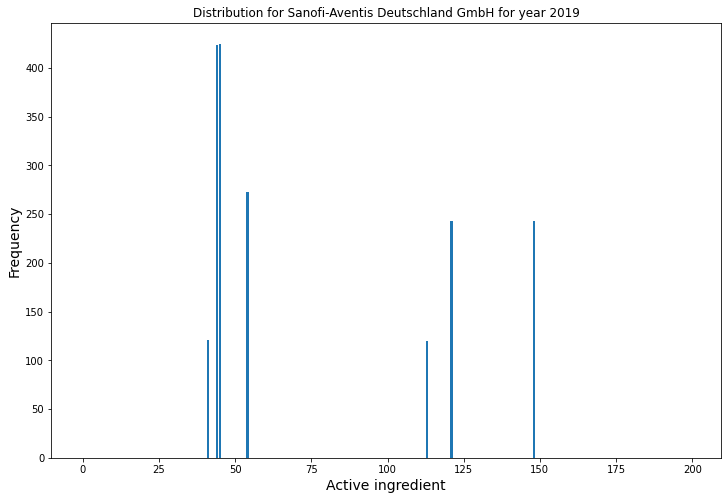

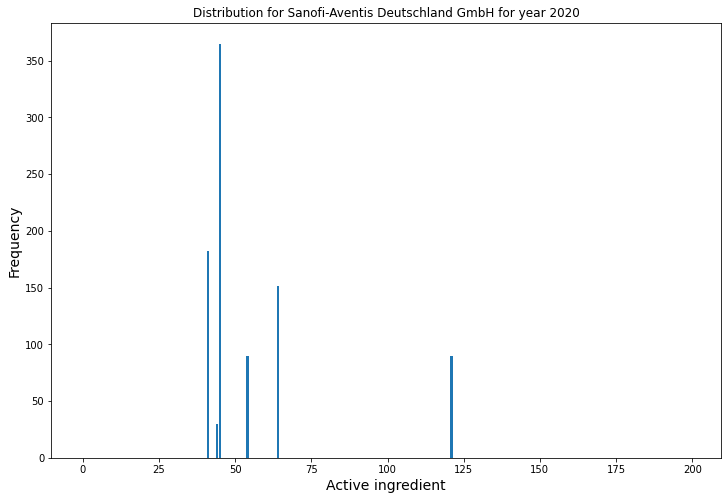

Sanofi-Aventis Deutschland GmbH (0.6744359504808712, 6.8477298034241625e-28)




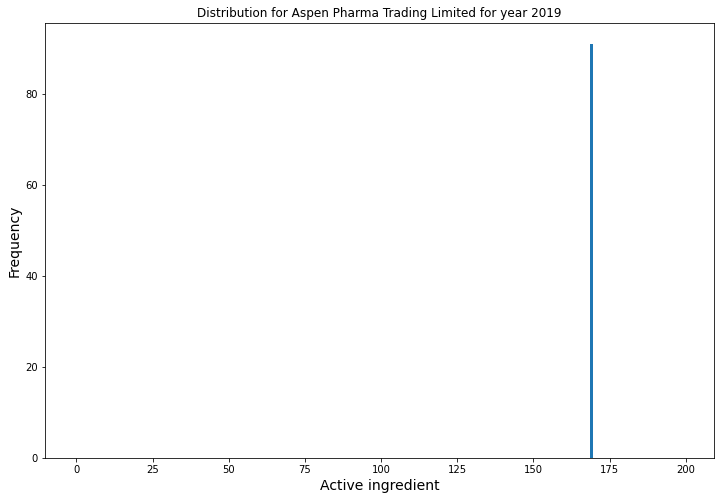

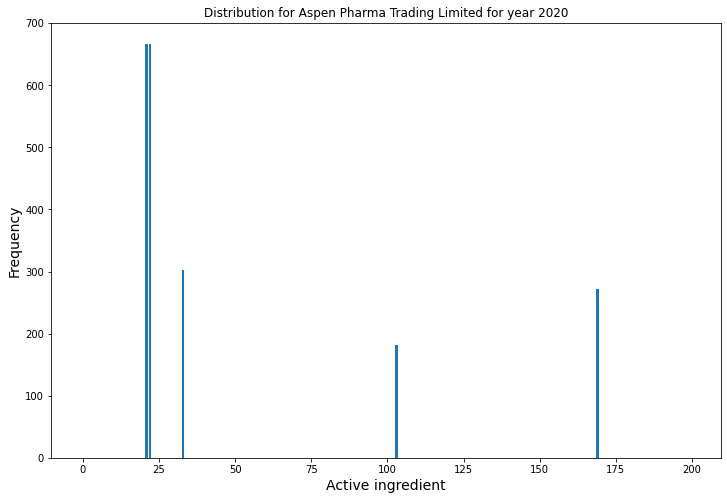

Aspen Pharma Trading Limited (0.25390104291331733, 0.0002858156046909969)




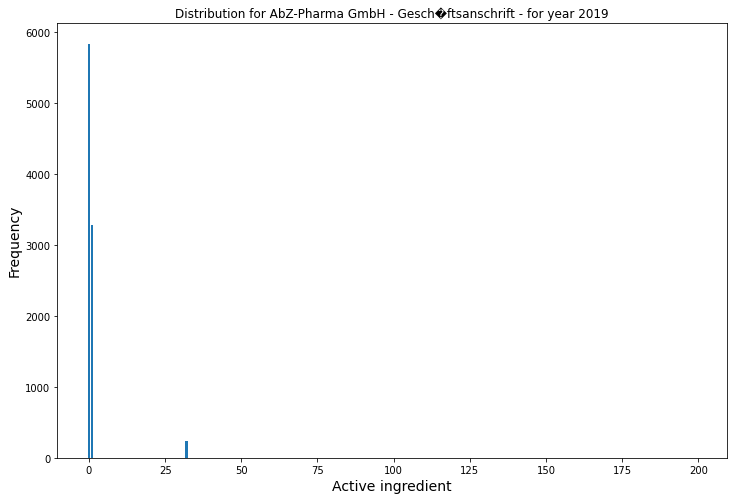

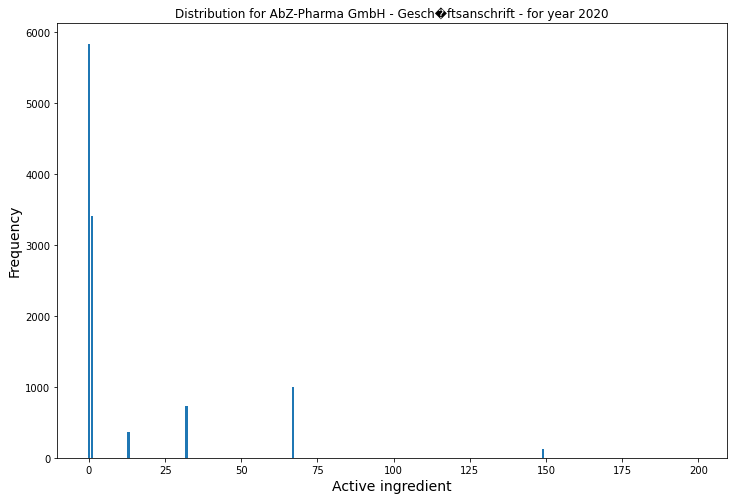

AbZ-Pharma GmbH - Gesch�ftsanschrift - (0.9851460081831391, 1.7923401740794533e-153)




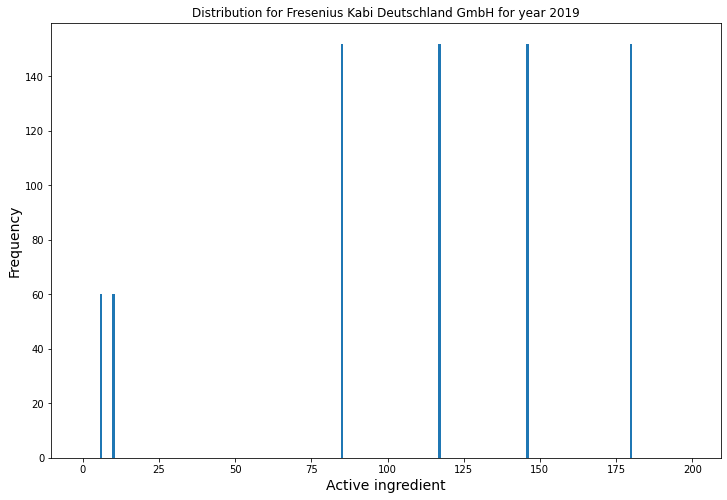

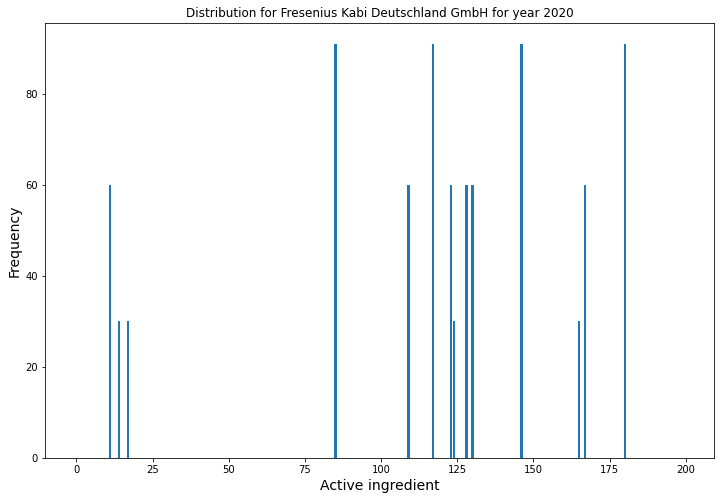

Fresenius Kabi Deutschland GmbH (0.717107053866197, 7.095400797275376e-33)




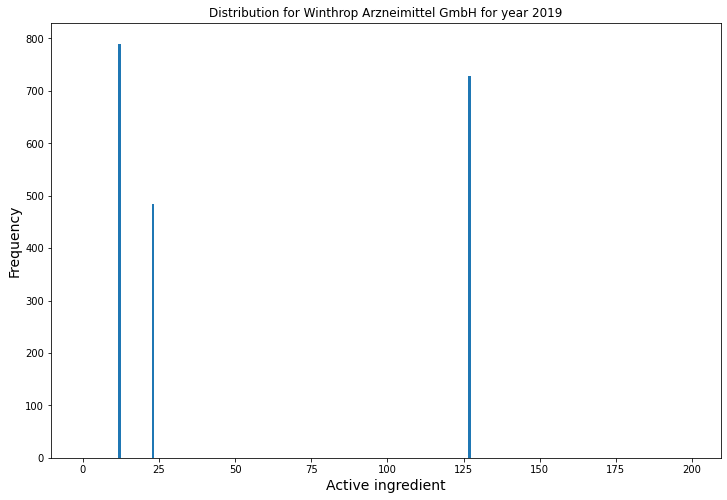

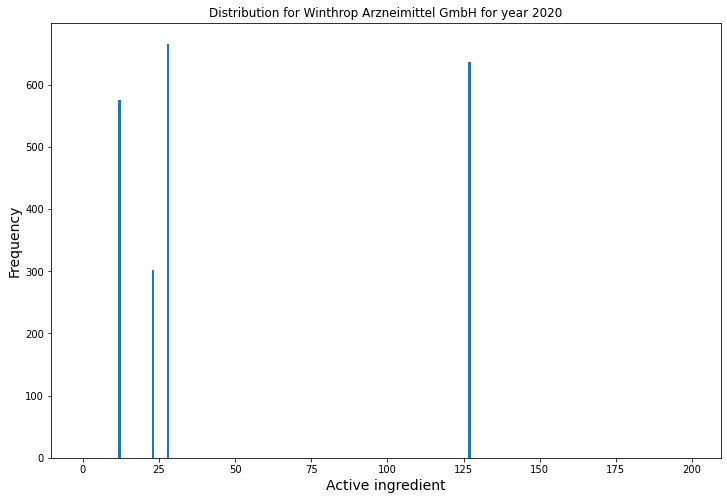

Winthrop Arzneimittel GmbH (0.7977472358221556, 2.2472337783955666e-45)




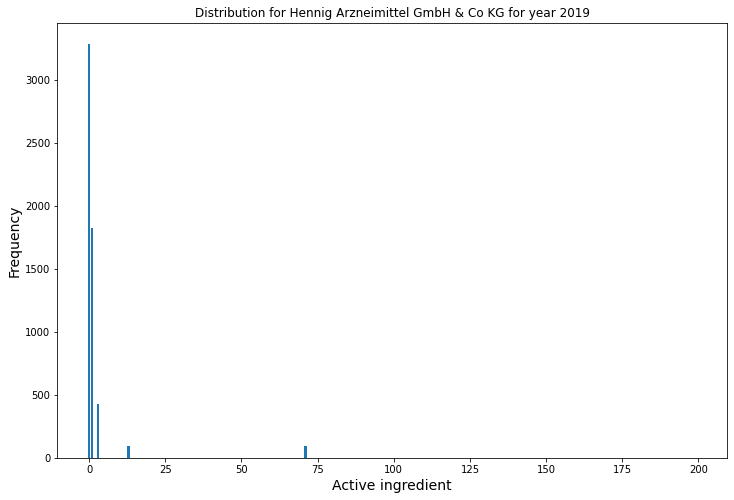

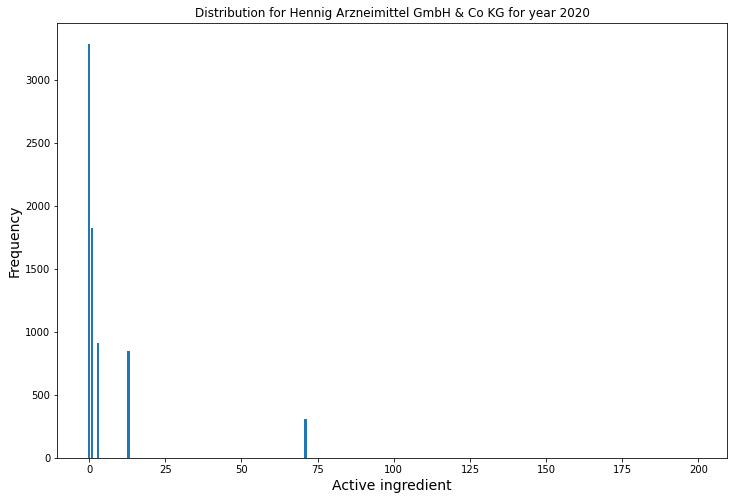

Hennig Arzneimittel GmbH & Co KG (0.9724675705105852, 3.278277453150126e-127)




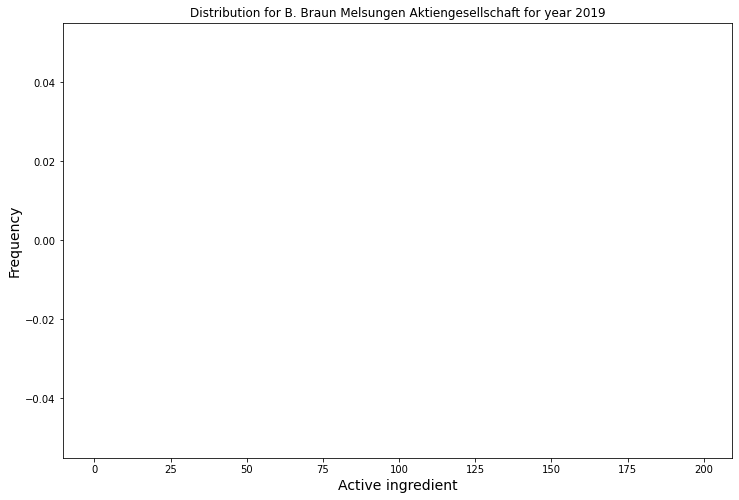

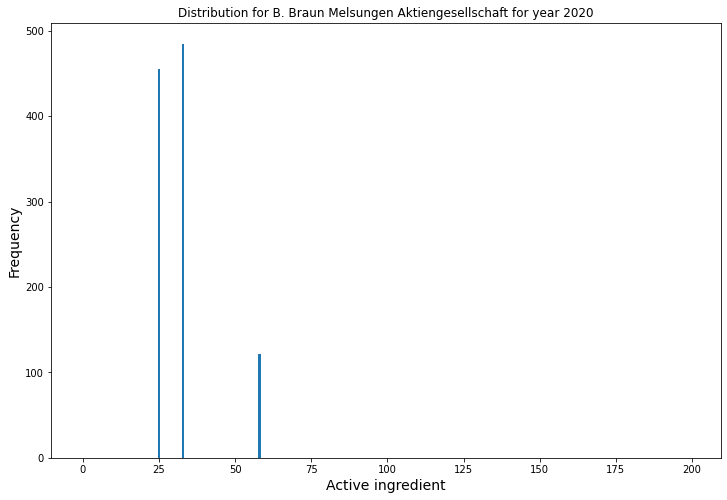

/home/koki/.local/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


B. Braun Melsungen Aktiengesellschaft (nan, nan)




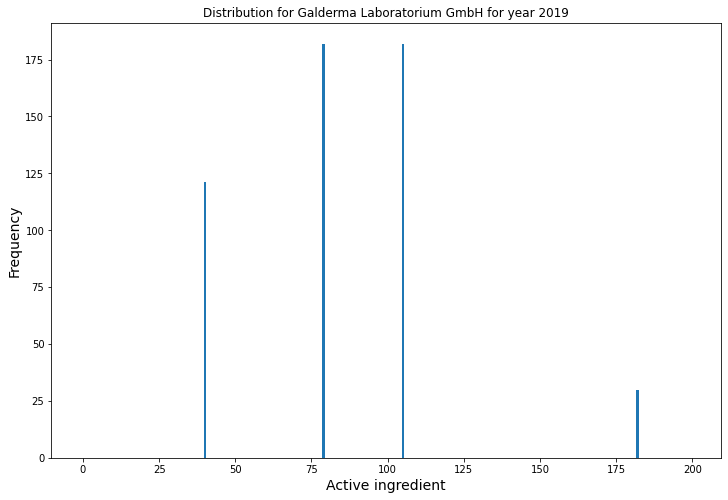

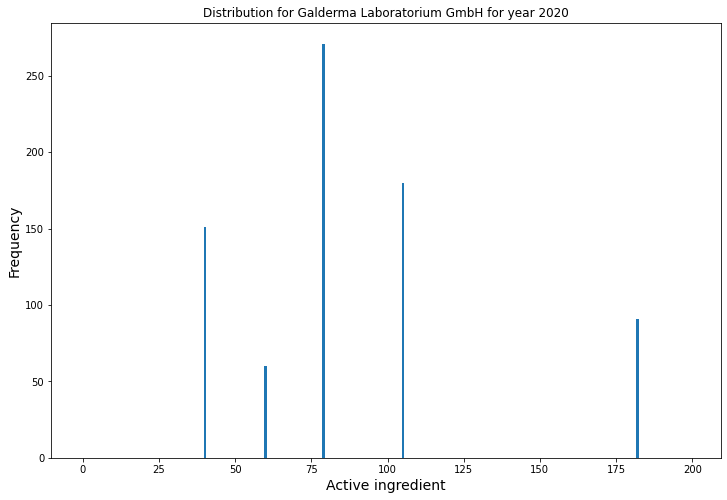

Galderma Laboratorium GmbH (0.9609360453302793, 2.0413089512971372e-112)




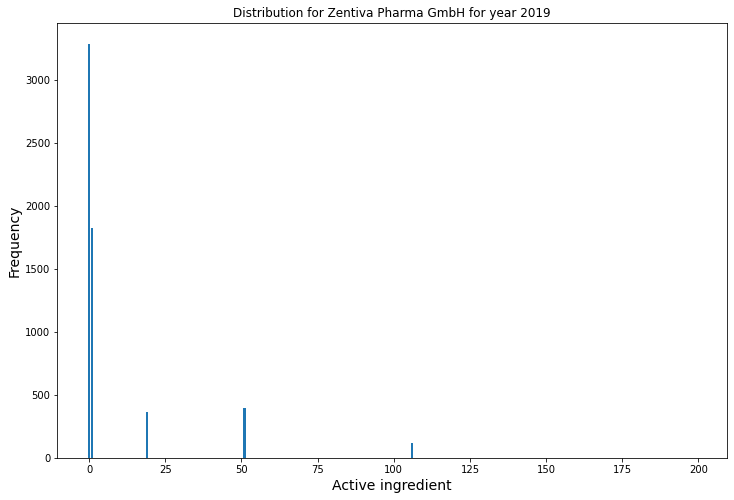

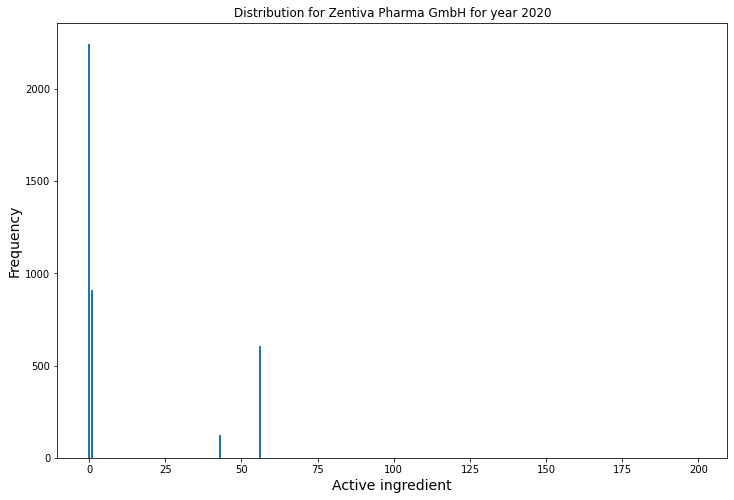

Zentiva Pharma GmbH (0.9508763338771165, 8.815274426745966e-103)




In [49]:
for comp, val in df['Zulassungsinhaber'].value_counts().items():
    if val > 20:
        vals19 = map2vec(plot_wirkstoff_distr_per_company_per_year(df, comp, 2019, top_ingredients_reports, top=200, 
                                                           plotit=True), top_ingredients_reports)
        vals20 = map2vec(plot_wirkstoff_distr_per_company_per_year(df, comp, 2020, top_ingredients_reports, top=200,
                                                           plotit=True), top_ingredients_reports)
        print(comp, pearsonr(vals19, vals20))
        print("\n")

In [50]:
def top_wirkstoffe_per_company(df, company, top=10):
    vals = {}
    df_comp = df[df["Zulassungsinhaber"]==company]
    for ws, days in zip(df_comp['wirkstoff'], df_comp['days']):
        for w in ws:
            vals.setdefault(w, 0)
            vals[w] += days/sum(df_comp['days'])
    top_vals = sorted([(v,k) for k, v in vals.items()], reverse=True)[:top]
    top_ingredients = [v[1] for v in top_vals]
    plt.figure(figsize=(12, 8))
    plt.bar(list(range(len(top_vals))), [v[0] for v in top_vals])
    plt.title("Distribution for " + company)
    plt.xlabel("Active ingredient", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    if top <=15:
        x_labels = top_ingredients[:top]
        x_labels = [" ".join(c.split()[:1]) for c in x_labels]
        plt.xticks(range(top), x_labels, fontsize=14, rotation=90)
    plt.show()    
    

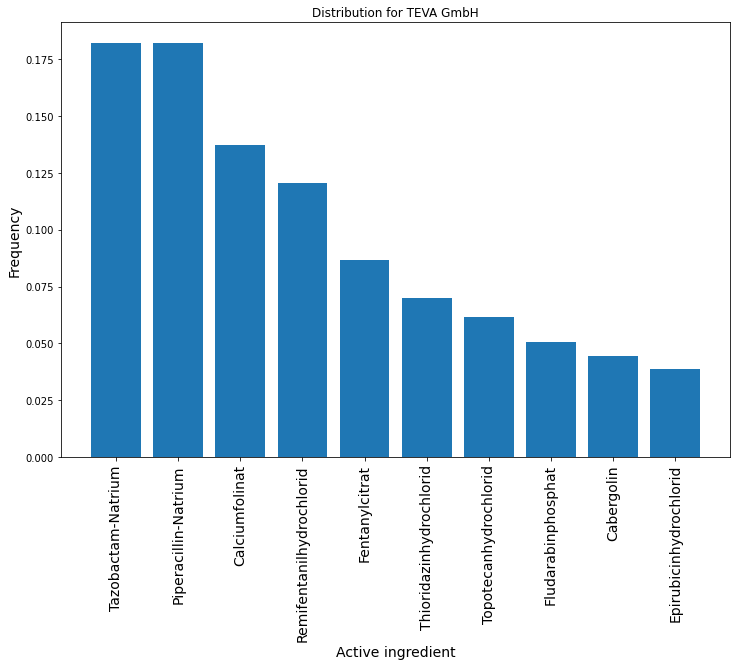

In [51]:
top_wirkstoffe_per_company(df, 'TEVA GmbH')

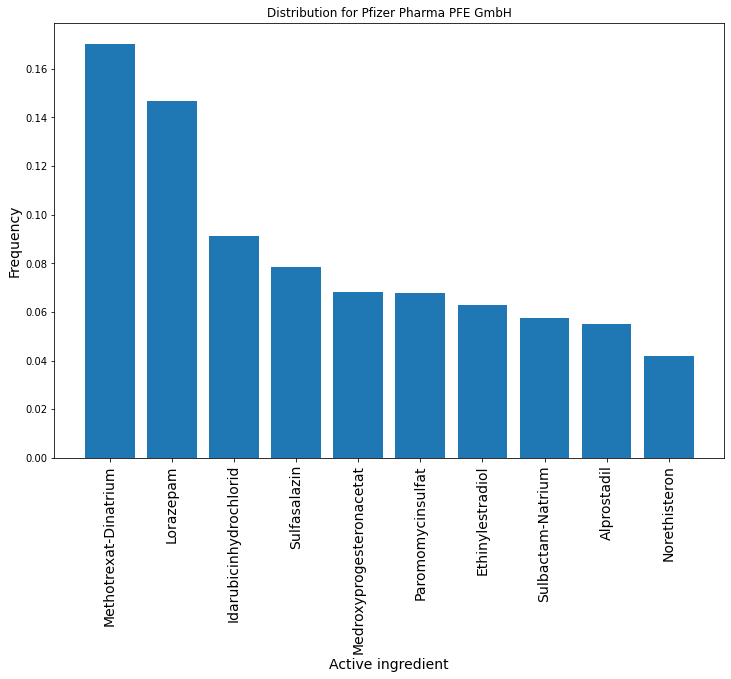

In [52]:
top_wirkstoffe_per_company(df, 'Pfizer Pharma PFE GmbH')

In [53]:
def merge_dicts(dict1, dict2):
    ''' Merge dictionaries and add up counters for identical values'''
    for key, value in dict2.items():
        if key in dict1:
            dict1[key] += value
        else:
            dict1[key] = value
    return dict1

In [54]:
d1 = {'a':1, 'b':2}
d2 = {'b':3, 'c':6}
merge_dicts(d1, d2)

{'a': 1, 'b': 5, 'c': 6}

In [55]:
def get_months_per_feature(df, featname):
    feature_dict = {}
    for _,row in df.iterrows():
        feat = list(np.array([row[featname]]).flatten())
        #print(feat)
        months_feat = row['months']
            # Counter(pd.date_range(row['Beginn'], row['Ende'], freq='MS').strftime("%b").tolist())
        for f in feat:
            feature_dict.setdefault(f, {})
            feature_dict[f] = merge_dicts(feature_dict[f], months_feat)
    return feature_dict
        

In [56]:
df[['Zulassungsinhaber', 'wirkstoff', 'Beginn', 'Ende', 'days', 'months', 'years']].head(10)

,Zulassungsinhaber,wirkstoff,Beginn,Ende,days,months,years
0,AstraZeneca GmbH,[Goserelinacetat],2021-11-11,2022-01-24,74,"{'Nov': 1, 'Dec': 1, 'Jan': 1}","{'2021': 60, '2022': 30}"
1,Hexal Aktiengesellschaft,[Octreotidacetat],2021-09-03,2022-01-29,148,"{'Sep': 1, 'Oct': 1, 'Nov': 1, 'Dec': 1, 'Jan'...","{'2021': 121, '2022': 30}"
2,Hexal Aktiengesellschaft,[Octreotidacetat],2021-10-29,2022-01-29,92,"{'Oct': 1, 'Nov': 1, 'Dec': 1, 'Jan': 1}","{'2021': 91, '2022': 30}"
3,Leo Pharma A/S Beiname: Leo Pharmaceutical Pro...,[Natriumfusidat],2021-10-11,2021-12-14,64,"{'Oct': 1, 'Nov': 1, 'Dec': 1}",{'2021': 91}
4,Leo Pharma A/S Beiname: Leo Pharmaceutical Pro...,[Natriumfusidat],2021-10-18,2021-10-19,1,{'Oct': 1},{'2021': 30}
5,Hexal Aktiengesellschaft,[Vinorelbinbis-tartrat]],2021-07-01,2022-03-25,267,"{'Jul': 1, 'Aug': 1, 'Sep': 1, 'Oct': 1, 'Nov'...","{'2021': 182, '2022': 91}"
6,1 A Pharma GmbH,[Rivastigmin],2021-09-17,2021-10-28,41,"{'Sep': 1, 'Oct': 1}",{'2021': 60}
7,Hexal Aktiengesellschaft,[Isotretinoin],2020-05-01,2021-11-30,578,"{'May': 2, 'Jun': 2, 'Jul': 2, 'Aug': 2, 'Sep'...","{'2020': 243, '2021': 334}"
8,ALIUD PHARMA GmbH,[Cefixim 3 H<2>O],2018-10-01,2021-12-31,1187,"{'Oct': 4, 'Nov': 4, 'Dec': 4, 'Jan': 3, 'Feb'...","{'2018': 91, '2019': 365, '2020': 365, '2021':..."
9,KEDRION S.p.A. Localita ai Conti,[Immunglobulin G vom Menschen],2021-10-01,2022-04-01,182,"{'Oct': 1, 'Nov': 1, 'Dec': 1, 'Jan': 1, 'Feb'...","{'2021': 91, '2022': 121}"


In [57]:
def get_years_distr(df):
    years_dict = {}
    for _,row in df.iterrows():
        row_dict = row['years'] 
            # Counter(pd.date_range(row['Beginn'], row['Ende'], freq='MS').strftime("%Y").tolist())
        years_dict = merge_dicts(years_dict, row_dict)
    return years_dict    

In [58]:
years_distr = get_years_distr(df)

In [59]:
def get_years_per_feature(df, featname):
    feature_dict = {}
    for _,row in df.iterrows():
        feat = list(np.array([row[featname]]).flatten())
        #print(feat)
        years_feat = row['years']
            # Counter(pd.date_range(row['Beginn'], row['Ende'], freq='MS').strftime("%Y").tolist())
        for f in feat:
            feature_dict.setdefault(f, {})
            feature_dict[f] = merge_dicts(feature_dict[f], years_feat)
    return feature_dict

In [60]:
company_per_year = get_years_per_feature(df, "Zulassungsinhaber")

In [61]:
wirkstoff_per_month = get_months_per_feature(df, "wirkstoff")

In [62]:
company_per_month = get_months_per_feature(df, "Zulassungsinhaber")

In [63]:
company_per_month

{'AstraZeneca GmbH': {'Nov': 1,
  'Dec': 2,
  'Jan': 2,
  'Mar': 1,
  'Apr': 1,
  'Feb': 1,
  'Sep': 2,
  'Oct': 1,
  'Jun': 2,
  'Jul': 2,
  'Aug': 1},
 'Hexal Aktiengesellschaft': {'Sep': 79,
  'Oct': 95,
  'Nov': 87,
  'Dec': 88,
  'Jan': 67,
  'Jul': 89,
  'Aug': 78,
  'Feb': 76,
  'Mar': 93,
  'May': 88,
  'Jun': 75,
  'Apr': 88},
 'Leo Pharma A/S Beiname: Leo Pharmaceutical Products Ltd. A/S': {'Oct': 2,
  'Nov': 1,
  'Dec': 3,
  'Jun': 2,
  'Jul': 1,
  'Jan': 2,
  'Feb': 2,
  'Mar': 1,
  'Apr': 2,
  'May': 1},
 '1 A Pharma GmbH': {'Sep': 50,
  'Oct': 49,
  'Nov': 50,
  'Dec': 45,
  'Jan': 32,
  'Feb': 35,
  'Mar': 48,
  'Apr': 49,
  'May': 45,
  'Jun': 40,
  'Jul': 55,
  'Aug': 51},
 'ALIUD PHARMA GmbH': {'Oct': 74,
  'Nov': 70,
  'Dec': 68,
  'Jan': 63,
  'Feb': 65,
  'Mar': 56,
  'Apr': 61,
  'May': 58,
  'Jun': 59,
  'Jul': 66,
  'Aug': 65,
  'Sep': 64},
 'KEDRION S.p.A. Localita ai Conti': {'Oct': 1,
  'Nov': 1,
  'Dec': 1,
  'Jan': 1,
  'Feb': 1,
  'Mar': 1,
  'Apr': 1},
 '

In [64]:
wirkstoff_per_month['Valsartan']

{'Aug': 249,
 'Sep': 247,
 'Jul': 248,
 'Oct': 251,
 'Nov': 251,
 'Dec': 246,
 'Jan': 192,
 'Feb': 193,
 'Mar': 171,
 'Apr': 159,
 'May': 160,
 'Jun': 159}

In [65]:
def plot_distr_per_month(hashmap, feature):
    vals = hashmap[feature]
    sumvals = sum(vals.values())
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    freq_series = pd.Series([vals[m]/sumvals for m in months])
    plt.figure(figsize=(12, 8))
    ax = freq_series.plot(kind='bar', alpha=0.75)
    ax.set_title('Monthly distribution for ' + feature, fontsize=15)
    # ax.set_xlabel('Active ingredient')
    ax.set_ylabel('Frequency', fontsize=14)
    ax.set_xticklabels(months, fontsize=14, rotation=70)
    plt.show()

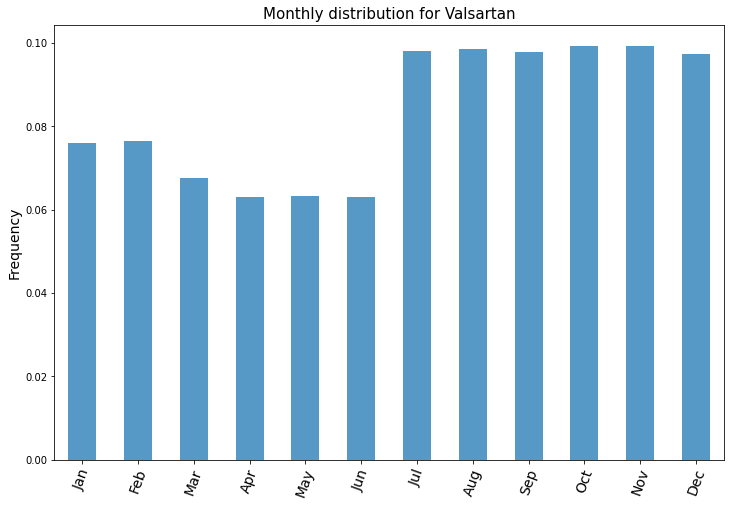

In [66]:
plot_distr_per_month(wirkstoff_per_month, 'Valsartan')

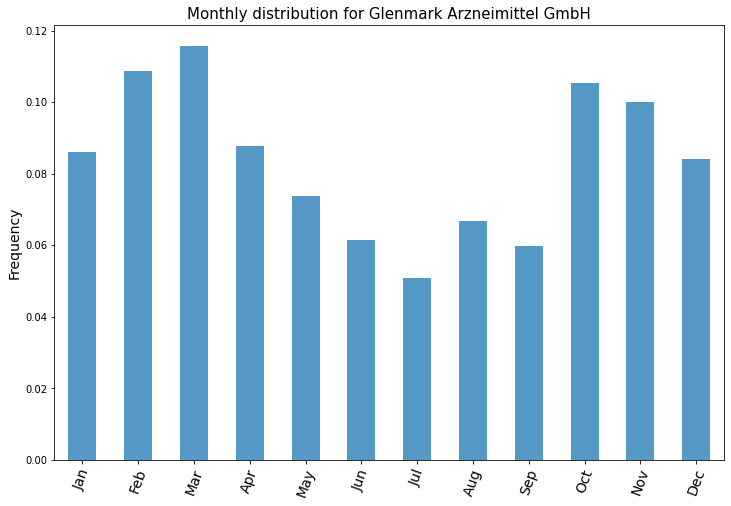

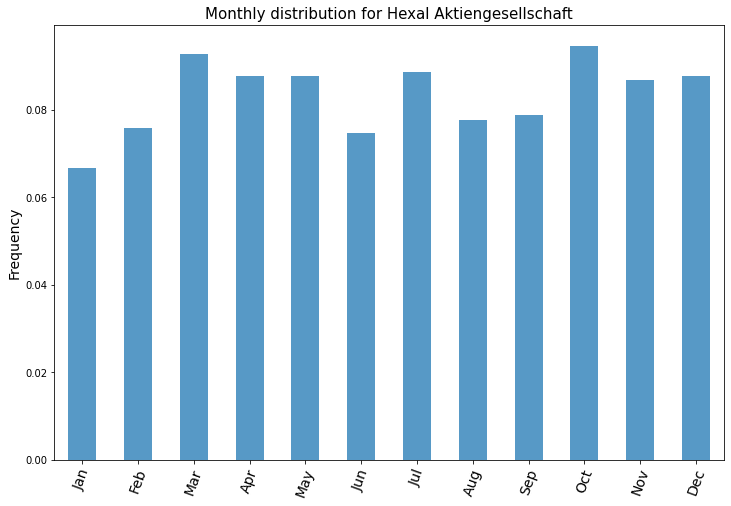

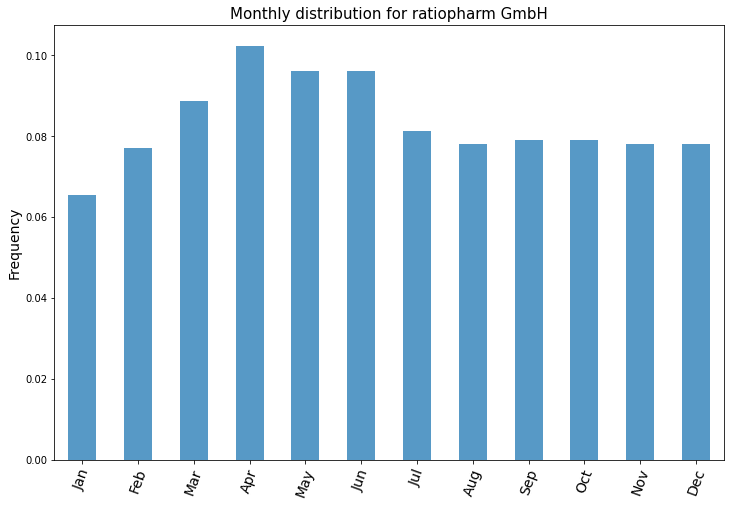

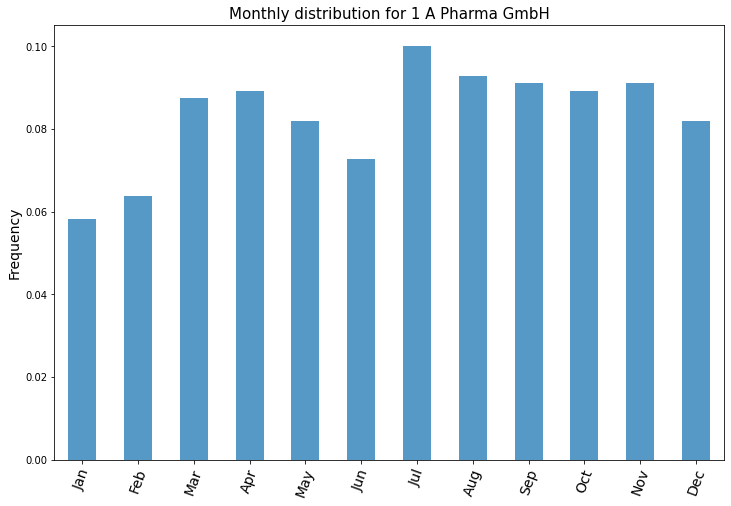

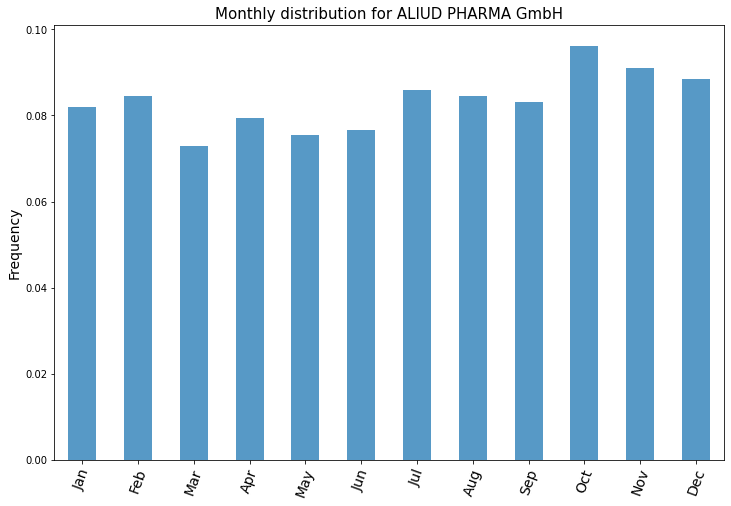

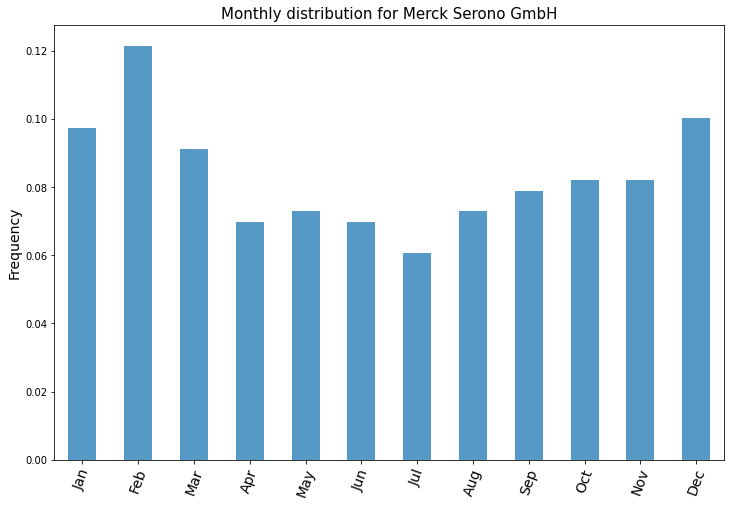

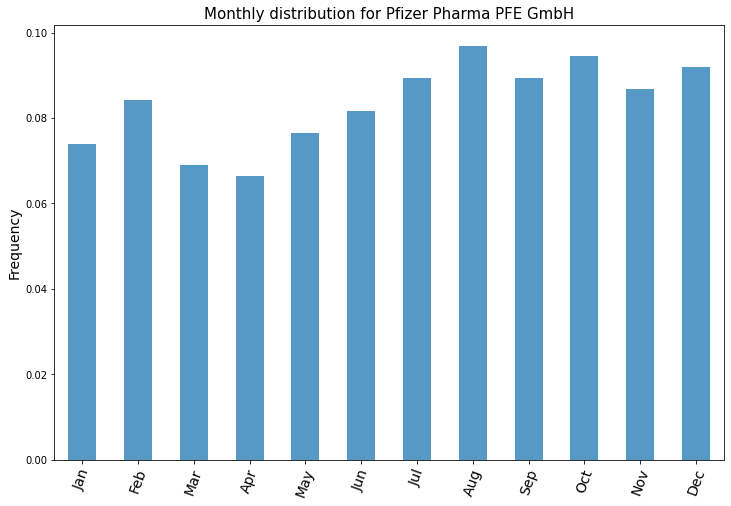

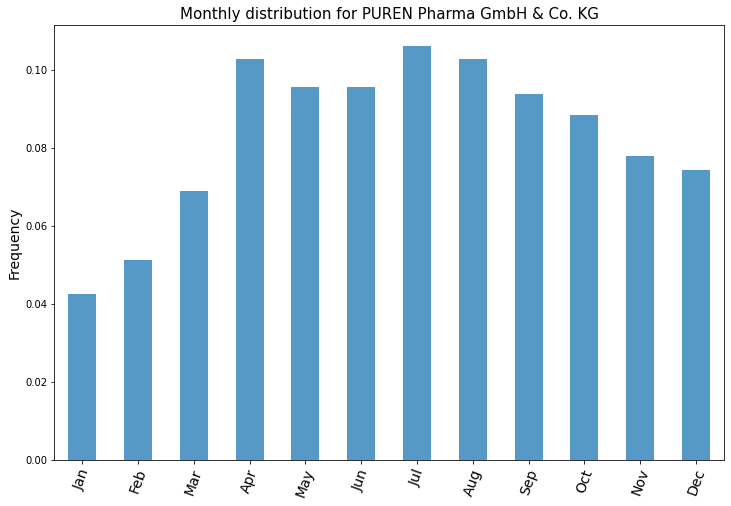

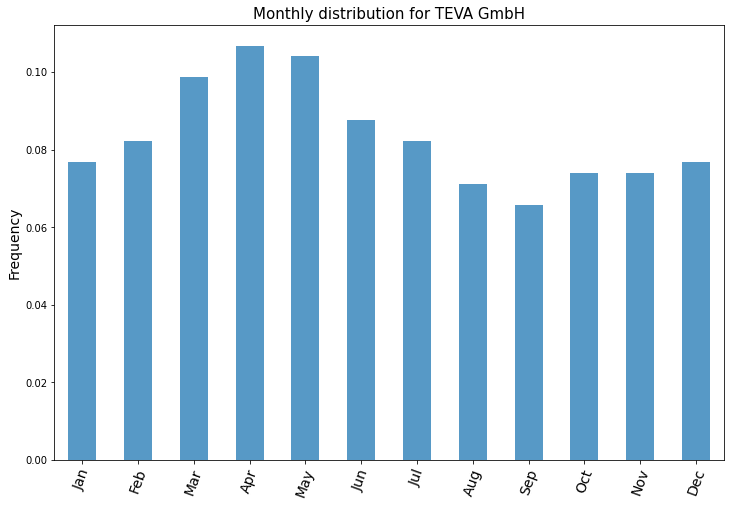

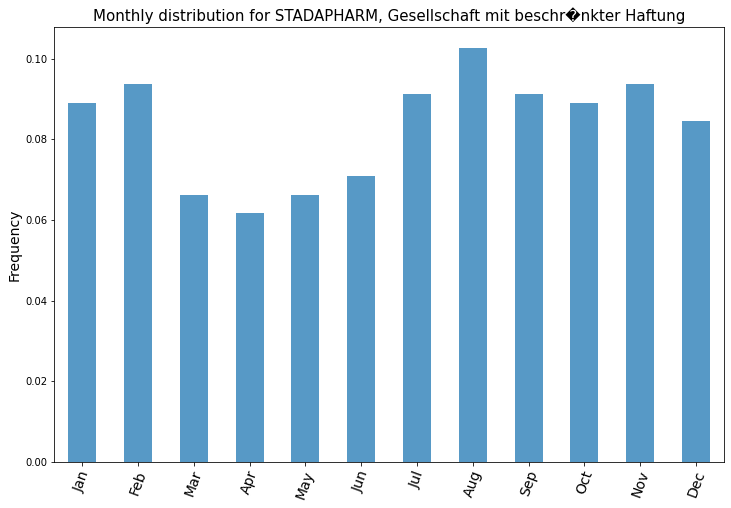

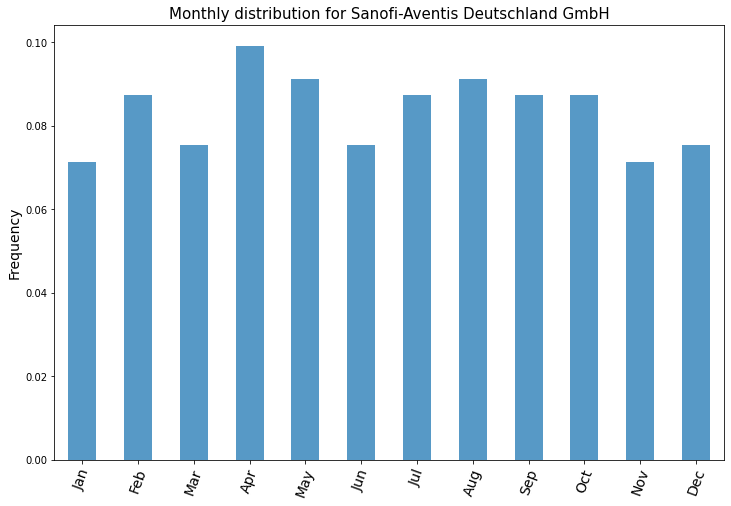

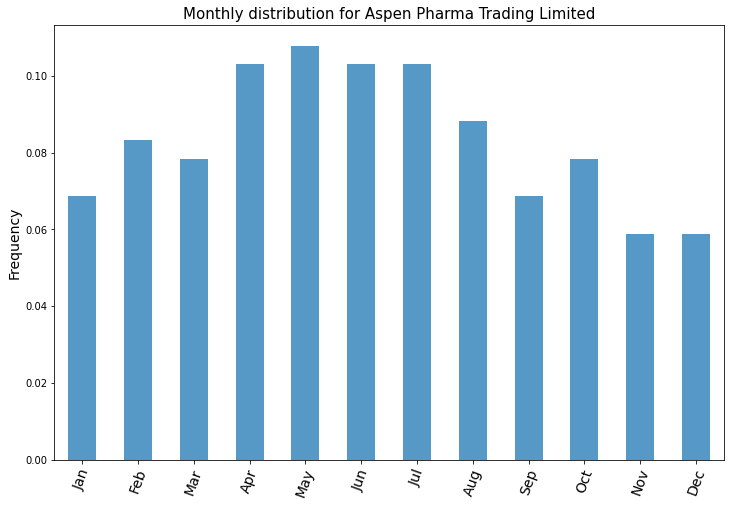

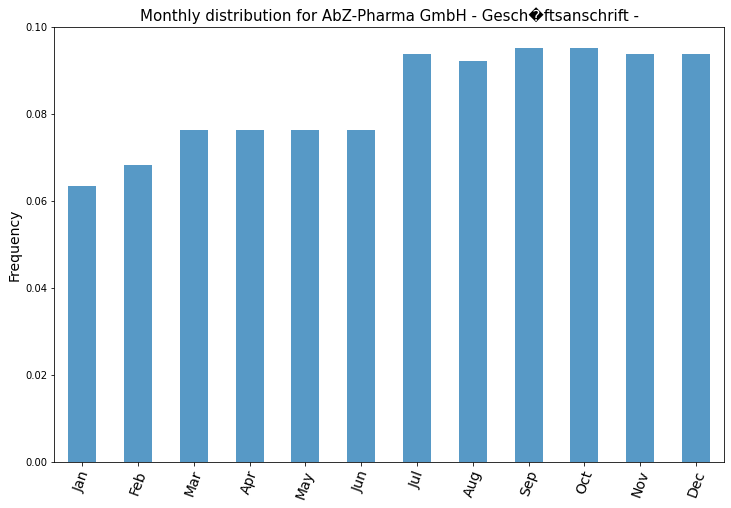

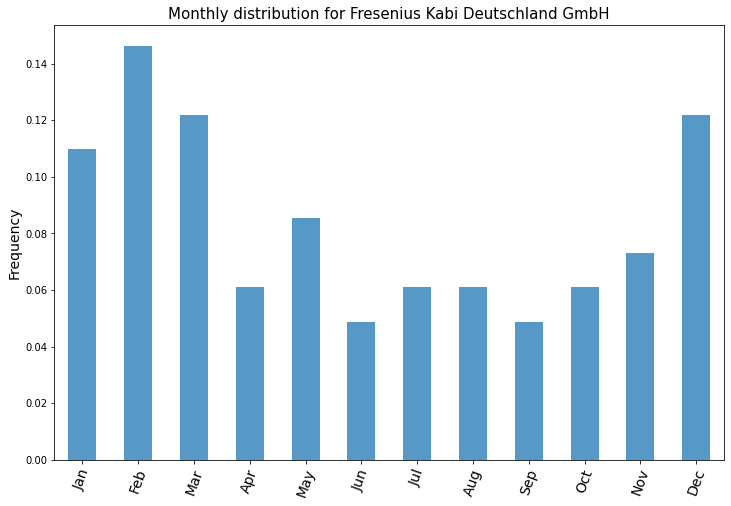

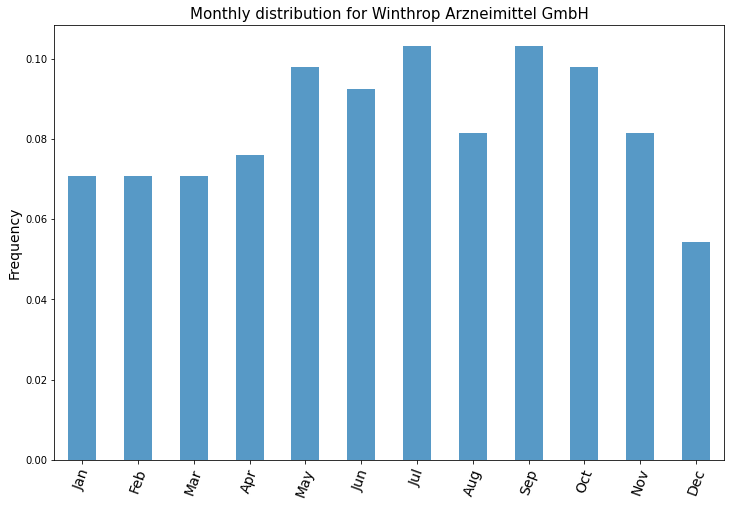

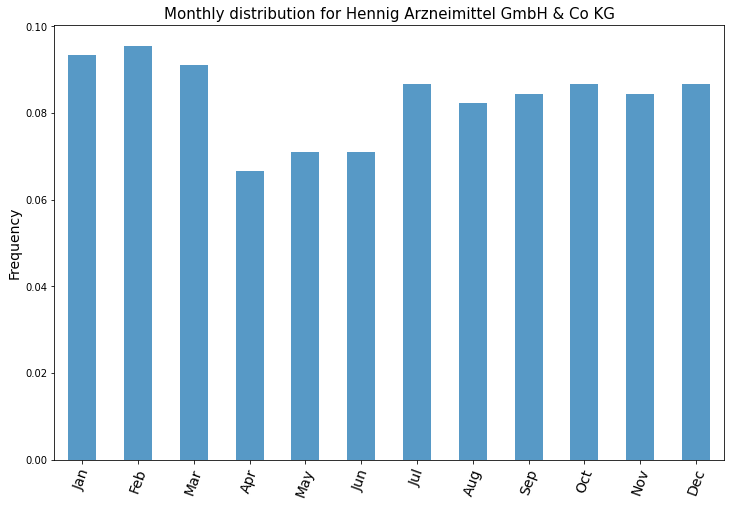

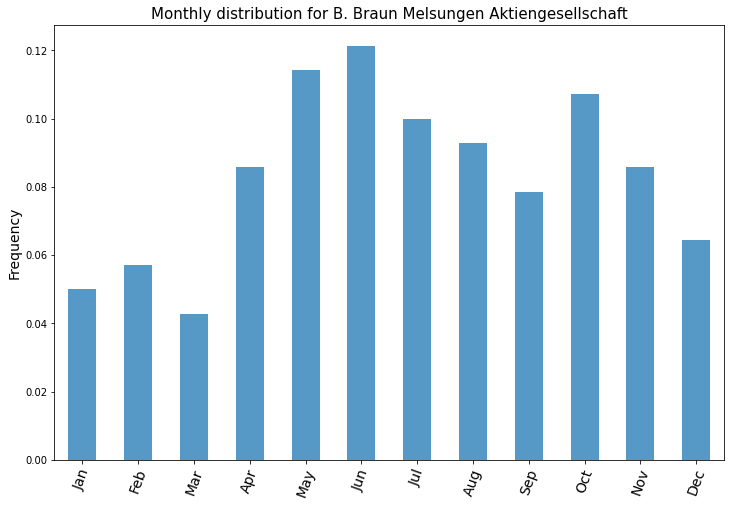

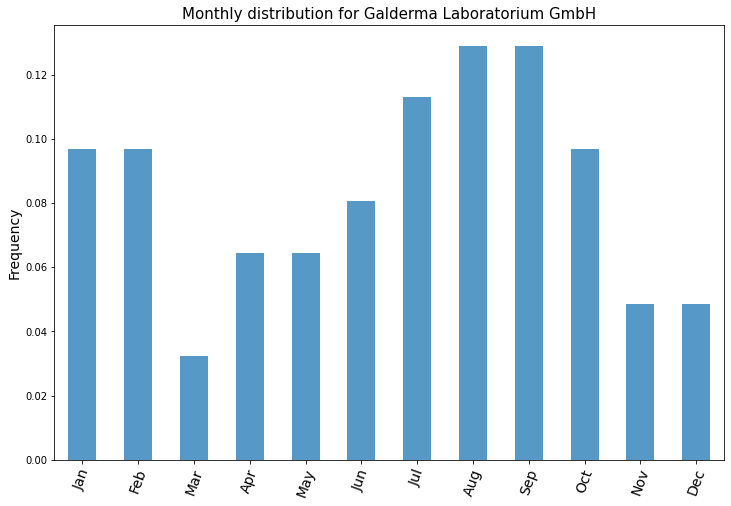

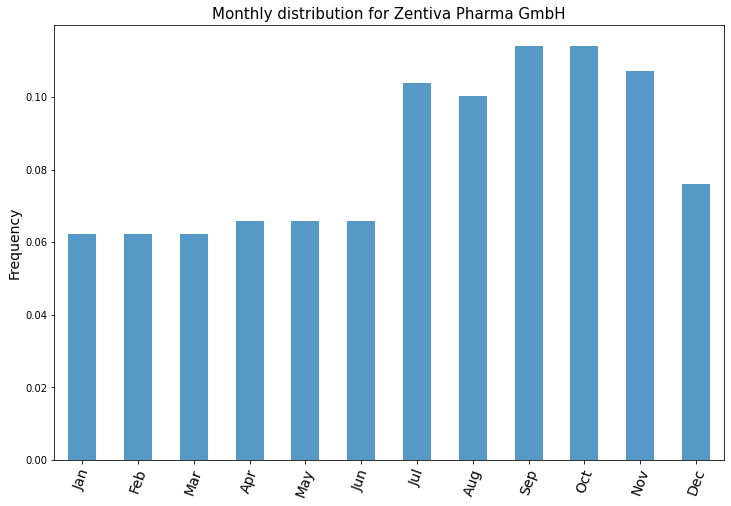

In [67]:
for comp, val in df['Zulassungsinhaber'].value_counts().items():
    if val > 20:
        plot_distr_per_month(company_per_month, comp)

In [68]:
df.head()

,PZN,ENR,Meldungsart,Beginn,Ende,Datum der letzten Meldung,Art des Grundes,Arzneimittlbezeichnung,Atc Code,Wirkstoffe,...,E-Mail,Grund,Anm. zum Grund,Alternativpr�parat,Datum der Erstmeldung,Info an Fachkreise,days,wirkstoff,months,years
0,"01008363, 04575772, 07591079",2139268,Erstmeldung,2021-11-11,2022-01-24,01.11.2021,Produktionsproblem,ZOLADEX-GYN,L02AE03,Goserelinacetat (1:x),...,service.center@astrazeneca.com,Sonstige,NaN,"Enantone-Gyn Monats-Depot 3,75mg Retardmikroka...",01.11.2021,Nein,74,[Goserelinacetat],"{'Nov': 1, 'Dec': 1, 'Jan': 1}","{'2021': 60, '2022': 30}"
1,"01128015, 06715970, 06715987",2163658,�nderungsmeldung,2021-09-03,2022-01-29,29.10.2021,Sonstige,Octreotid HEXAL 100 Mikrogramm/ml,H01CB02,Octreotidacetat (1:x),...,service@hexal.com,Sonstige,NaN,NaN,03.09.2021,Vorgesehen,148,[Octreotidacetat],"{'Sep': 1, 'Oct': 1, 'Nov': 1, 'Dec': 1, 'Jan'...","{'2021': 121, '2022': 30}"
2,"06715993, 06716001",2163657,Erstmeldung,2021-10-29,2022-01-29,29.10.2021,Sonstige,Octreotid HEXAL 50 Mikrogramm/ml,H01CB02,Octreotidacetat (1:x),...,service@hexal.com,Sonstige,NaN,NaN,29.10.2021,Vorgesehen,92,[Octreotidacetat],"{'Oct': 1, 'Nov': 1, 'Dec': 1, 'Jan': 1}","{'2021': 91, '2022': 30}"
3,01872392,424272,�nderungsmeldung,2021-10-11,2021-12-14,28.10.2021,Produktionsproblem,Fucidine 20 mg/g Salbe,D06AX01,Natriumfusidat,...,regulatory_affairs_de@leo-pharma.com,Probleme in der Herstellung,NaN,Fucidine 20 mg/g Salbe - Einreichungsnummer: 0...,11.10.2021,Nein,64,[Natriumfusidat],"{'Oct': 1, 'Nov': 1, 'Dec': 1}",{'2021': 91}
4,01462323,424272,L�schmeldung,2021-10-18,2021-10-19,28.10.2021,Produktionsproblem,Fucidine 20 mg/g Salbe,D06AX01,Natriumfusidat,...,regulatory_affairs_de@leo-pharma.com,Probleme in der Herstellung,NaN,Fucidine 20 mg/g Salbe - Einreichungsnummer: 0...,11.10.2021,Nein,1,[Natriumfusidat],{'Oct': 1},{'2021': 30}


In [69]:
min(df['Beginn'])

Timestamp('2012-06-01 00:00:00')

In [70]:
def plot_distr_per_year(years_distr):
    years = sorted(years_distr.keys())
    freq_series = pd.Series([years_distr[y] for y in years])
    plt.figure(figsize=(12, 8))
    ax = freq_series.plot(kind='bar', alpha=0.75)
    ax.set_title('Per year distribution for all companies', fontsize=15)
    # ax.set_xlabel('Active ingredient')
    ax.set_ylabel('Frequency', fontsize=14)
    ax.set_xticklabels(years, fontsize=14, rotation=70)
    plt.show()

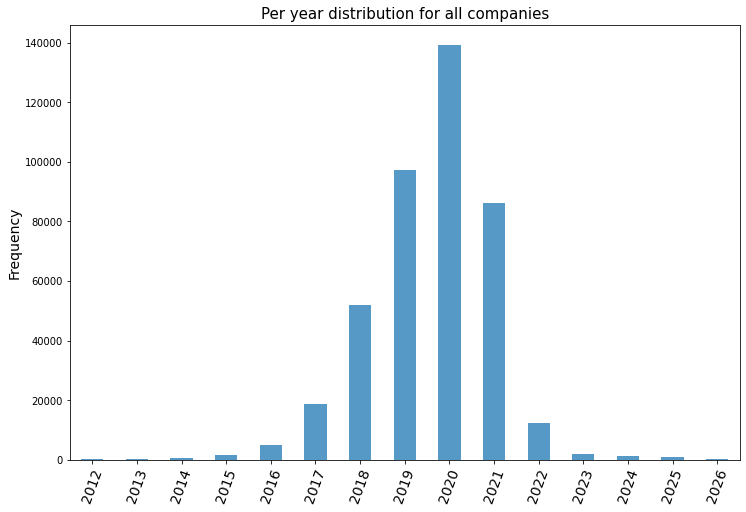

In [71]:
plot_distr_per_year(years_distr)

In [78]:
df[df['Beginn'] >= dt.datetime(2021,11,30)]

,PZN,ENR,Meldungsart,Beginn,Ende,Datum der letzten Meldung,Art des Grundes,Arzneimittlbezeichnung,Atc Code,Wirkstoffe,...,E-Mail,Grund,Anm. zum Grund,Alternativpr�parat,Datum der Erstmeldung,Info an Fachkreise,days,wirkstoff,months,years
50,"02014147, 02014153",338101,Erstmeldung,2022-01-01,2022-01-31,20.10.2021,Sonstige,Furadantin RP,J01XE01,Nitrofurantoin,...,IHeimann@productlife-group.com,Sonstige,NaN,Furadantin Retard - Einreichungsnummer: 0338087,20.10.2021,Nein,30,[Nitrofurantoin],"{'Jan': 1, 'Feb': 1}",{'2022': 60}
52,"01272953, 01272976",338087,Erstmeldung,2022-02-01,2022-02-28,19.10.2021,Sonstige,Furadantin Retard,J01XE01,Nitrofurantoin,...,IHeimann@productlife-group.com,Sonstige,NaN,Furadantin RP - Einreichungsnummer: 0338101,19.10.2021,Nein,27,[Nitrofurantoin],{'Feb': 1},{'2022': 30}
150,"05505911, 05505928, 05505934",2169430,Erstmeldung,2021-12-01,2022-02-28,14.09.2021,Produktionsproblem,Vincristinsulfat-TEVA 1 mg/ml Injektionsl�sung,L01CA02,Vincristinsulfat,...,gks-post@ratiopharm.de,Probleme in der Herstellung,NaN,NaN,14.09.2021,Ja,89,[Vincristinsulfat],"{'Dec': 1, 'Jan': 1, 'Feb': 1}","{'2021': 30, '2022': 60}"
231,"08828187, 08828201, 08828282",2182615,Erstmeldung,2022-02-15,2022-05-15,05.08.2021,Produktionsproblem,Idarubicin HEXAL 1 mg/ml Konzentrat zur Herste...,L01DB06,Idarubicinhydrochlorid,...,service@hexal.com,Probleme in der Herstellung,NaN,NaN,05.08.2021,Vorgesehen,89,[Idarubicinhydrochlorid],"{'Feb': 1, 'Mar': 1, 'Apr': 1, 'May': 1}",{'2022': 121}


In [91]:
def set_beginn(x, year):
    return max(x, dt.datetime(year, 1, 1))
def set_ende(x, year):
    return min(x, dt.datetime(year, 12, 31))

In [115]:
def get_df_year(df, year):
    df_year = deepcopy(df)
    df_year['Beginn'+str(year)] = df_year.apply(lambda row: set_beginn(row['Beginn'], year), axis=1)
    df_year['Ende'+str(year)] = df_year.apply(lambda row: set_ende(row['Ende'], year), axis=1)
    df_year = df_year[(df_year['Beginn'+str(year)] <= dt.datetime(year, 12, 31)) & \
                (df_year['Ende'+str(year)] >= dt.datetime(year, 1, 1))]
    df_year['days'] = (df_year['Ende'+str(year)] - df_year['Beginn'+str(year)]).dt.days
    months = []
    for _,row in df_year.iterrows():
        months_feat = Counter(pd.date_range(row['Beginn'+str(year)], row['Ende'+str(year)]+ \
                                            pd.DateOffset(days=29), 
                                        freq='M').strftime("%b").tolist())
        months.append([k for k, v in months_feat.items()])
    
    df_year['months'] = months   
    return df_year

In [125]:
df18 = get_df_year(df, 2018)
df19 = get_df_year(df, 2019)
df20 = get_df_year(df, 2020)
df21 = get_df_year(df, 2021)

In [117]:
df19.shape, df20.shape, df21.shape

((550, 25), (821, 25), (516, 25))

In [118]:
df19[['Beginn', 'Ende', 'days', 'months']]

,Beginn,Ende,days,months
8,2018-10-01,2021-12-31,364,"[Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, ..."
46,2019-07-01,2022-06-30,183,"[Jul, Aug, Sep, Oct, Nov, Dec]"
47,2019-07-01,2022-06-30,183,"[Jul, Aug, Sep, Oct, Nov, Dec]"
78,2019-10-01,2022-12-31,91,"[Oct, Nov, Dec]"
130,2019-01-01,2021-09-24,364,"[Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, ..."
...,...,...,...,...
1403,2018-11-01,2019-01-31,30,"[Jan, Feb]"
1409,2018-10-01,2019-01-31,30,"[Jan, Feb]"
1411,2018-02-01,2019-01-31,30,"[Jan, Feb]"
1485,2018-07-01,2019-04-30,119,"[Jan, Feb, Mar, Apr]"


In [129]:
def plot_months_distr(df, year, comp = None):
    months_distr = {}
    if comp is not None:
        df = df[df["Zulassungsinhaber"]==comp]
    for _, row in df.iterrows():
        for m in row['months']:
            months_distr.setdefault(m, 0)
            months_distr[m] += 1
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    freq_series = pd.Series([months_distr[m] for m in months])
    plt.figure(figsize=(12, 8))
    ax = freq_series.plot(kind='bar', alpha=0.75)
    str_comp = ""
    if comp is not None:
        str_comp = " for " + comp
    ax.set_title('Monthly distribution for ' + str(year) + str_comp, fontsize=15)
    # ax.set_xlabel('Active ingredient')
    ax.set_ylabel('Frequency', fontsize=14)
    ax.set_xticklabels(months, fontsize=14, rotation=70)
    plt.show()   

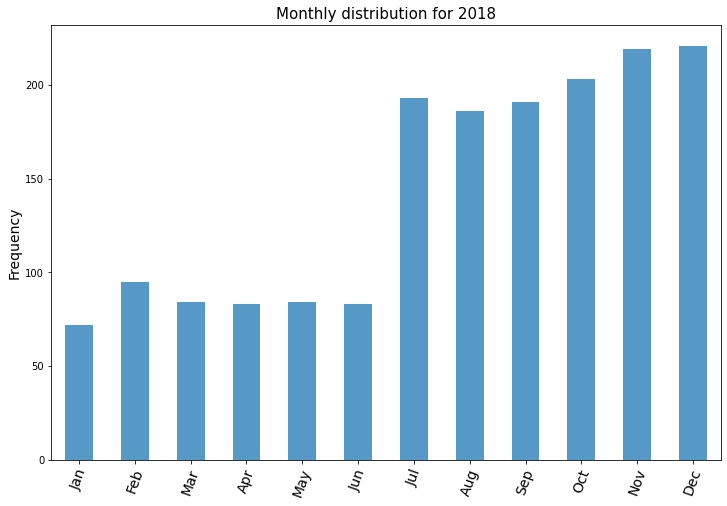

In [130]:
plot_months_distr(df18, 2018)

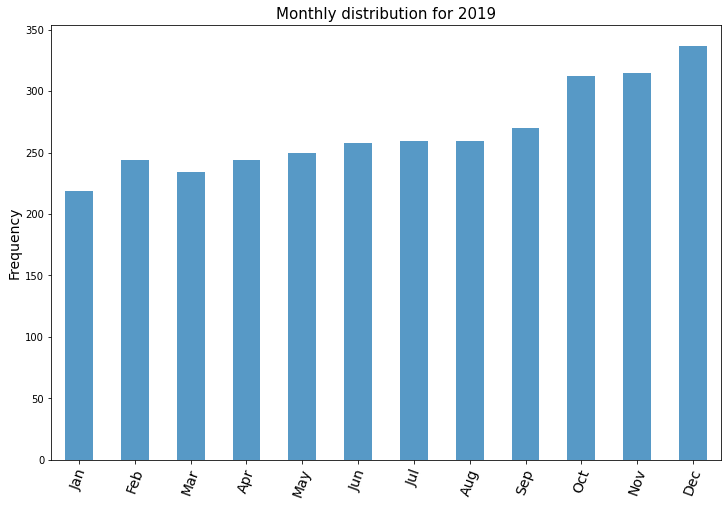

In [131]:
plot_months_distr(df19, 2019)

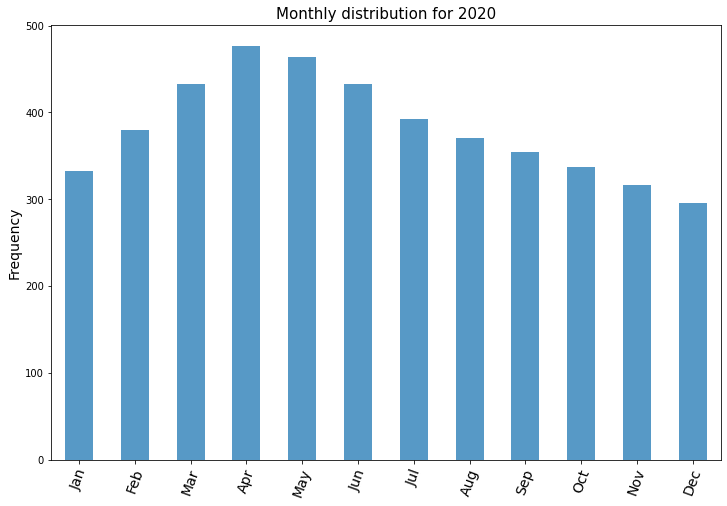

In [132]:
plot_months_distr(df20, 2020)

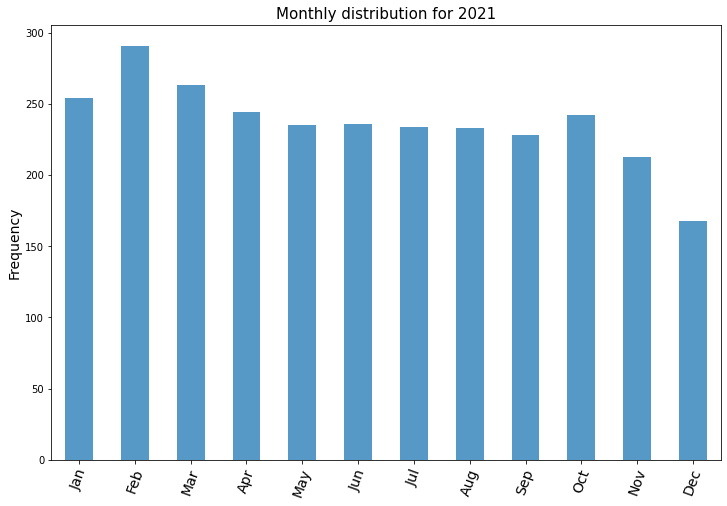

In [133]:
plot_months_distr(df21, 2021)

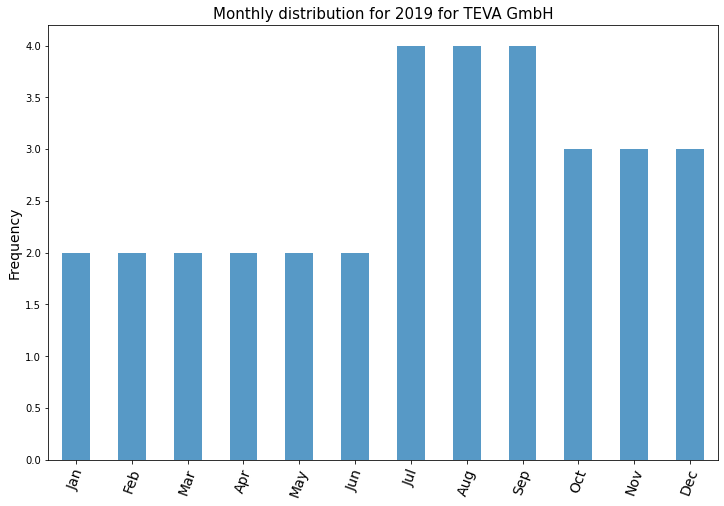

In [134]:
plot_months_distr(df19, 2019, comp='TEVA GmbH')

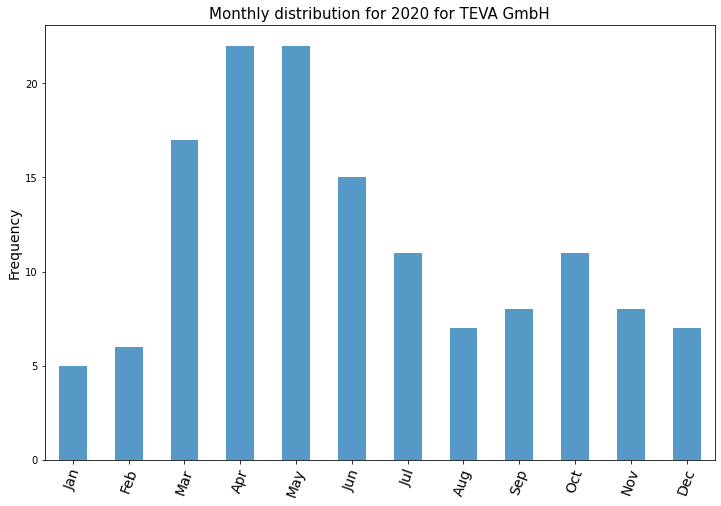

In [136]:
plot_months_distr(df20, 2020, comp='TEVA GmbH')

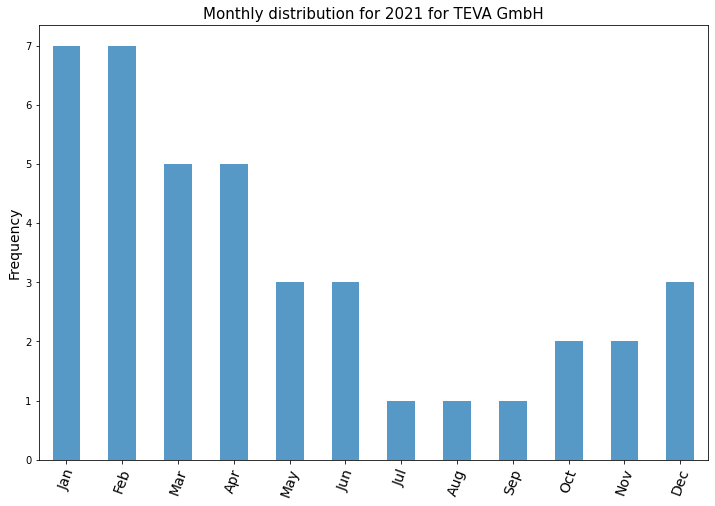

In [137]:
plot_months_distr(df21, 2021, comp='TEVA GmbH')